In [295]:
import os
import pandas as pd
import numpy as np
import networkx as nx 
import matplotlib.pyplot as plt
from community import community_louvain 
from networkx.algorithms.community.quality import modularity, performance, coverage
from networkx.algorithms.cuts import conductance
from sklearn.metrics import adjusted_rand_score, rand_score, normalized_mutual_info_score


In [296]:
def read_data(num_nodes=-1):

    """ Reads data of politician, their party and who they follow into df_data """

    members = pd.read_csv('raw_data/raw_data/all_congress_members.csv')
    members['current_twitter_name'] = members['new_twitter_name'].fillna(members['twitter_name'])

    df_data = pd.DataFrame()
    df_data[['current_twitter_name','party']] = members[['current_twitter_name','party']].copy()
    if num_nodes != -1:
        df_data = df_data.head(num_nodes)

    following_data = []
    
    for twitter_name in df_data['current_twitter_name']:
        filename = f"twitterExport_{twitter_name}_Following.csv"
        filepath = os.path.join('raw_data/raw_data/following_data_raw', filename)

        if os.path.exists(filepath):
            followed_users = pd.read_csv(filepath)['user_name'].tolist()
        else:
            followed_users = []
        
        following_data.append(followed_users)

    df_data['following'] = following_data
    df_data = df_data[df_data['following'].apply(lambda x: x != [])]

    return df_data

In [297]:
def build_network(df_data, k, hits):

    """ Builds network of politicians, with edges between them if they share k followers """

    G = nx.Graph()
    
    # Add nodes
    names = df_data['current_twitter_name'].tolist()
    parties = df_data['party'].tolist()
    for name, party in zip(names, parties):
        G.add_node(name, party=party) 
    
    # Add edges based on shared following
    for i in range(len(df_data)):
        for j in range(i + 1, len(df_data)):
            # Get the sets of following of each politcian
            # Uses the "important_following" column if we incorporate hits, otherwise defaults to the "following" column
            if hits:
                following_i = set(df_data.iloc[i]['important_following'])
                following_j = set(df_data.iloc[j]['important_following'])
            else:
                following_i = set(df_data.iloc[i]['following'])
                following_j = set(df_data.iloc[j]['following'])
            
            # Get the shared following
            shared_following = following_i.intersection(following_j)
            if len(shared_following) >= k:
                G.add_edge(names[i], names[j])
    
    return G

In [298]:
def build_hits_network_and_store(df_data):

    """ Builds directed network using politicians and their followings as nodes
    and directed edges based on if one node follows the other. This is to calculate HITS values for each
    person a politician follows to determine importance """

    G = nx.DiGraph()

    # Add edges based on the politicians and the people they follow
    for _, row in df_data.iterrows():
        politician = row['current_twitter_name']
        following_list = row['following']  # List of people the politician follows
        
        # Add the politician as a node
        G.add_node(politician, party=row['party'])
        
        # Add edges for each person the politician follows
        for followee in following_list:
            G.add_node(followee)  # Add the followed account as a node
            G.add_edge(politician, followee)  # Directed edge from politician to followed account

    # Compute HITS scores
    hub_scores, authority_scores = nx.hits(G, max_iter=100, tol=1e-7)

    # Store the HITS scores as node attributes
    for node in G.nodes():
        G.nodes[node]['hub_score'] = hub_scores.get(node, 0)
        G.nodes[node]['authority_score'] = authority_scores.get(node, 0)
    
    return G, list(authority_scores.values())

In [299]:
def add_important_following_column(G, df_data, auth_thresh):

    """ Use calculated HITS values to add new column of the following if 
    they are above the authority value threshold """

    # Create a set of nodes to retain
    retained_nodes = set()
    for node in G.nodes:
        if G.nodes[node]['authority_score'] >= auth_thresh or (
            node in df_data['current_twitter_name'].values):
            retained_nodes.add(node)

    # Create a new column 'important_following'
    important_following = []
    for _, row in df_data.iterrows():
        following_list = row['following']
        
        # Filter the followings to retain only those in the retained_nodes set
        filtered_following = [f for f in following_list if f in retained_nodes]
        important_following.append(filtered_following)

    # Add the new column to the dataframe
    df_data['important_following'] = important_following
    return df_data

In [300]:
def louvain_two_communities(G):

    """ Run the Louvain algorithm to detect communities """

    partition = community_louvain.best_partition(G)
    
    # Map nodes to their initial communities
    initial_communities = {}
    for node, community in partition.items():
        if community not in initial_communities:
            initial_communities[community] = set()
        initial_communities[community].add(node)
    
    # Force the split into two communities by grouping smaller communities
    # into two larger ones based on modularity or proximity
    community1, community2 = set(), set()
    for idx, community_nodes in enumerate(initial_communities.values()):
        if idx % 2 == 0:
            community1.update(community_nodes)
        else:
            community2.update(community_nodes)
    
    # Create the final two-community split
    communities = [community1, community2]
    node_to_community = {}
    for node in community1:
        node_to_community[node] = 1
    for node in community2:
        node_to_community[node] = 2

    # Calculate modularity value
    # mod_value = modularity(G, communities)
    # print(f"Modularity of the two-community split: {mod_value}")

    # Analyze alignment with political parties
    alignment = {1: {"R": 0, "D": 0}, 2: {"R": 0, "D": 0}}
    for node in G.nodes():
        party = G.nodes[node]['party']
        if node in community1:
            alignment[1][party] += 1
        else:
            alignment[2][party] += 1

    # print("\nCommunity-party alignment:")
    # for community_id, counts in alignment.items():
    #     print(f"Community {community_id}: {counts}")
    

    return communities, alignment, node_to_community #, mod_value

In [301]:
def visualise_graph(G, communities, spacing, title):

    """ Visualise graph coloured red and blue for R and D classed by louvain algorithm respectively """
    
    community1 = communities[0]
    plt.figure(figsize=(20, 15))
    node_colors = []
    for node in G.nodes():
        if node in community1:
            node_colors.append('red')
        else:
            node_colors.append('lightskyblue')

    pos = nx.spring_layout(G, k=spacing/np.sqrt(len(G.nodes())), iterations=20)
    nx.draw(
        G, pos=pos, with_labels=True, node_color=node_colors, node_size=2000, font_size=6
    )
    plt.title(title, fontsize=16)
    plt.show()
    

In [302]:
def graph_info(G):

    """ Gives basic info on the graph """

    print("Number of nodes:", G.number_of_nodes())
    print("Number of edges:", G.number_of_edges())
    print("Degree of each node:", G.degree())
    print("Nodes in the graph:", G.nodes())
    print("Edges in the graph:", G.edges())
    print("Graph density:", nx.density(G))
    
    # Degree Distribution
    degrees = [degree for _, degree in G.degree()]
    degree_count = {degree: degrees.count(degree) for degree in set(degrees)}
    print("Degree Distribution:", degree_count)
    
    # Plot Degree Distribution
    plt.figure(figsize=(20,15))
    plt.bar(degree_count.keys(), degree_count.values())
    plt.title("Degree Distribution")
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.show()

    # Average Shortest Path Length
    if nx.is_connected(G):
        avg_shortest_path_length = nx.average_shortest_path_length(G)
        print("Average Shortest Path Length:", avg_shortest_path_length)
    else:
        print("Graph is not connected. Calculating for each connected component...")
        for i, component in enumerate(nx.connected_components(G), start=1):
            subgraph = G.subgraph(component)
            avg_length = nx.average_shortest_path_length(subgraph)
            print(f"Component {i}: Average Shortest Path Length = {avg_length}")

    # # Mixing Patterns: Degree Assortativity
    # degree_assortativity = nx.degree_assortativity_coefficient(G)
    # print("Degree Assortativity Coefficient:", degree_assortativity)

    attribute_assortativity = nx.attribute_assortativity_coefficient(G, "party")
    print("Party Assortativity Coefficient:", attribute_assortativity)




In [303]:
# def calculate_metrics(alignment):

#     """ Calculate accuracy, precision, recall, and F1 score from alignment data """
    
#     # Extract counts
#     true_positive_R = alignment[1]["R"]
#     false_positive_R = alignment[1]["D"]
#     true_positive_D = alignment[2]["D"]
#     false_positive_D = alignment[2]["R"]
    
#     # Total counts
#     total = sum(sum(values.values()) for values in alignment.values())
#     correct = true_positive_R + true_positive_D
    
#     # Accuracy
#     accuracy = correct / total
    
#     # Precision and Recall for R
#     precision_R = true_positive_R / (true_positive_R + false_positive_R) if (true_positive_R + false_positive_R) > 0 else 0
#     recall_R = true_positive_R / (true_positive_R + false_positive_D) if (true_positive_R + false_positive_D) > 0 else 0
    
#     # Precision and Recall for D
#     precision_D = true_positive_D / (true_positive_D + false_positive_D) if (true_positive_D + false_positive_D) > 0 else 0
#     recall_D = true_positive_D / (true_positive_D + false_positive_R) if (true_positive_D + false_positive_R) > 0 else 0
    
#     # F1 Score for R and D
#     f1_R = (2 * precision_R * recall_R) / (precision_R + recall_R) if (precision_R + recall_R) > 0 else 0
#     f1_D = (2 * precision_D * recall_D) / (precision_D + recall_D) if (precision_D + recall_D) > 0 else 0
    
#     # Macro Average (Optional)
#     precision_macro = (precision_R + precision_D) / 2
#     recall_macro = (recall_R + recall_D) / 2
#     f1_macro = (f1_R + f1_D) / 2
    
#     return {
#         "accuracy": accuracy,
#         "precision_R": precision_R,
#         "recall_R": recall_R,
#         "f1_R": f1_R,
#         "precision_D": precision_D,
#         "recall_D": recall_D,
#         "f1_D": f1_D,
#         "precision_macro": precision_macro,
#         "recall_macro": recall_macro,
#         "f1_macro": f1_macro
#     }

In [304]:
def calculate_metrics(alignment, node_to_community, G, communities):
    """
    Calculate FFC, ARI, RI, and NMI from alignment data and graph nodes.

    Parameters:
        alignment (dict): Alignment data of communities to political parties.
        node_to_community (dict): Mapping of nodes to their assigned community.
        G (Graph): The graph with nodes and party information.

    Returns:
        dict: Calculated metrics.
    """
    # Extract counts
    true_positive_R = alignment[1]["R"]
    false_positive_R = alignment[1]["D"]
    true_positive_D = alignment[2]["D"]
    false_positive_D = alignment[2]["R"]
    # Precision and Recall for R
    precision_R = true_positive_R / (true_positive_R + false_positive_R) if (true_positive_R + false_positive_R) > 0 else 0
    recall_R = true_positive_R / (true_positive_R + false_positive_D) if (true_positive_R + false_positive_D) > 0 else 0
    
    # Precision and Recall for D
    precision_D = true_positive_D / (true_positive_D + false_positive_D) if (true_positive_D + false_positive_D) > 0 else 0
    recall_D = true_positive_D / (true_positive_D + false_positive_R) if (true_positive_D + false_positive_R) > 0 else 0

    # Macro Average (Optional)
    precision_macro = (precision_R + precision_D) / 2
    recall_macro = (recall_R + recall_D) / 2

    # Total nodes in the graph
    total_correct = 0
    total_nodes = sum(sum(counts.values()) for counts in alignment.values())

    for _, counts in alignment.items():
        # Total nodes in this community
        community_size = sum(counts.values())

        # Majority reference community
        majority_count = max(counts.values())

        # Check if the majority reference community constitutes at least half the nodes
        if majority_count >= community_size / 2:
            total_correct += majority_count
        # If not, all nodes in the community are misclassified (implicitly adds 0)

    # Normalize by the total number of nodes
    fcc = total_correct / total_nodes

    # Extract true labels and predicted labels from the alignment
    true_labels = []
    predicted_labels = []
    for node in G.nodes():
        true_party = 1 if G.nodes[node]['party'] == 'R' else 2  # Map "R" -> 1, "D" -> 2
        true_labels.append(true_party)
        predicted_labels.append(node_to_community[node])

    # Adjusted Rand Index (ARI)
    ari = adjusted_rand_score(true_labels, predicted_labels)

    # Rand Index (RI)
    ri = rand_score(true_labels, predicted_labels)

    # Normalized Mutual Information (NMI)
    nmi = normalized_mutual_info_score(true_labels, predicted_labels)

    mod_value = modularity(G, communities)
    coverage_value = coverage(G, communities)
    performance_value = performance(G, communities)
    filtered_communities = []
    for community in communities:
        volume_S = sum(G.degree(node) for node in community)
        volume_T = sum(G.degree(node) for node in set(G.nodes) - set(community))
        
        if volume_S > 0 and volume_T > 0:
            filtered_communities.append(community)

    conductance_values = [conductance(G, community) for community in filtered_communities]
    avg_conductance = sum(conductance_values) / len(conductance_values) if conductance_values else 0


    return {
        "fcc": fcc,
        "ari": ari,
        "ri": ri,
        "nmi": nmi,
        "precision": precision_macro,
        "recall": recall_macro,
        "modularity": mod_value,
        "coverage": coverage_value,
        "performance": performance_value,
        "conductance": avg_conductance
    }


In [305]:
""" PARAMETERS """

# num of politicians used out of 164 total (-1 means all politicians)
num_nodes = -1 
# min num of shared followers to have a link
follow_thresh = 21 
# spacing between the network nodes (higher value gives more spacing)
spacing = 15

In [306]:
df_data = read_data(num_nodes)

**Without HITS values**

Number of nodes: 164
Number of edges: 9872
Degree of each node: [('SpeakerRyan', 84), ('SpeakerPelosi', 93), ('michelebachmann', 124), ('dwstweets', 129), ('EricCantor', 150), ('keithellison', 149), ('alangrayson', 63), ('jasoninthehouse', 143), ('StenyHoyer', 121), ('reptomprice', 142), ('repkarenbass', 140), ('maxinewaters', 121), ('repjohnlewis', 44), ('RepJamesClyburn', 146), ('aaronschock', 134), ('roslehtinen', 144), ('stevekingia', 83), ('cathymcmorris', 149), ('vernbuchanan', 142), ('jim_jordan', 140), ('cbrangel', 146), ('reppeteking', 68), ('danarohrabacher', 31), ('repjoebarton', 101), ('michaelcburgess', 146), ('DrPhilGingrey', 145), ('peterroskam', 145), ('robwittman', 150), ('chairmanmckeon', 89), ('patrickmchenry', 128), ('tomrooney', 139), ('chrisvanhollen', 142), ('KristiNoem', 94), ('repsteveisrael', 151), ('repshimkus', 147), ('randy_forbes', 150), ('PaulBrounforGA', 141), ('repmikehonda', 117), ('virginiafoxx', 139), ('repmikecoffman', 145), ('janschakowsky', 148), 

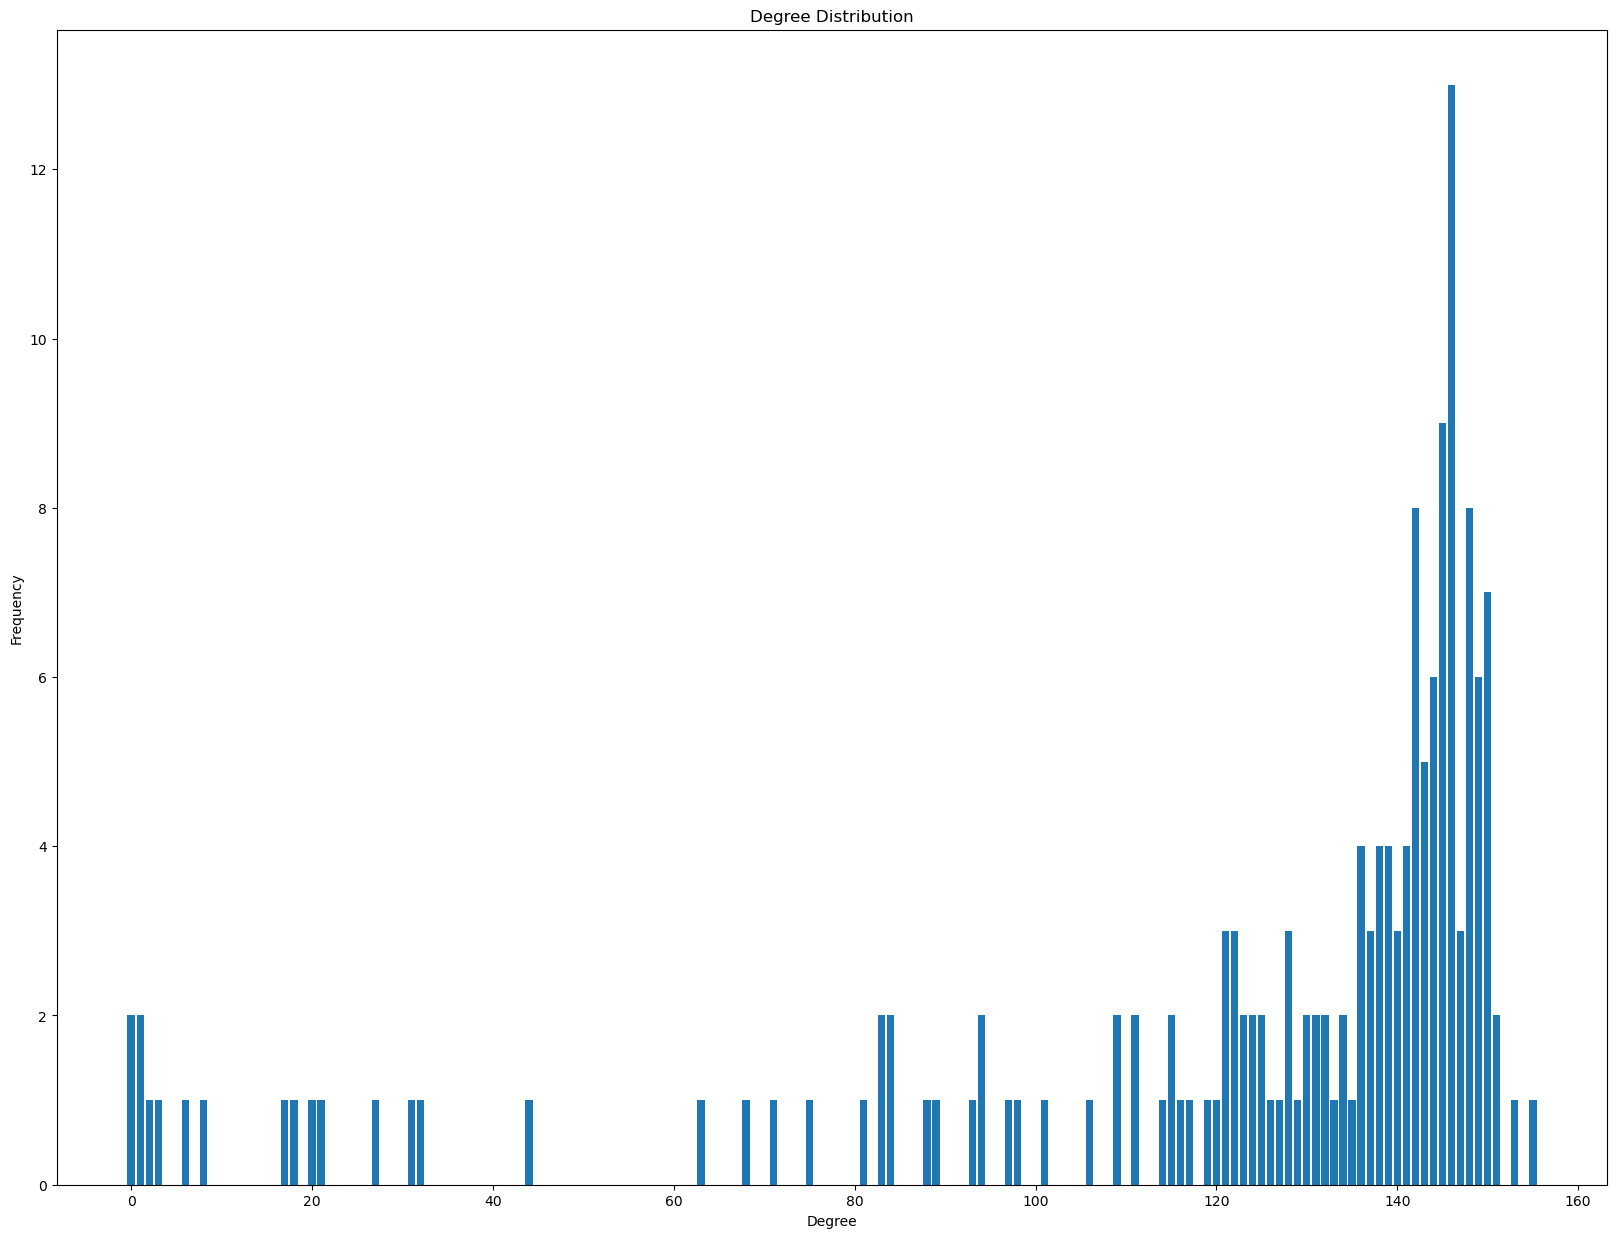

Graph is not connected. Calculating for each connected component...
Component 1: Average Shortest Path Length = 1.2470669427191166
Component 2: Average Shortest Path Length = 0
Component 3: Average Shortest Path Length = 0
Party Assortativity Coefficient: 0.10342703389851805


In [307]:
G = build_network(df_data, follow_thresh, False)
graph_info(G)

{1: {'R': 87, 'D': 1}, 2: {'R': 4, 'D': 72}}
{'fcc': 0.9695121951219512, 'ari': 0.881041981148963, 'ri': 0.9405207242256471, 'nmi': 0.8104007662345354, 'precision': 0.9680023923444976, 'recall': 0.9711726629534849, 'modularity': 0.050945615835695235, 'coverage': 0.5570299837925445, 'performance': 0.5846176866676642, 'conductance': 0.49789365820334736}


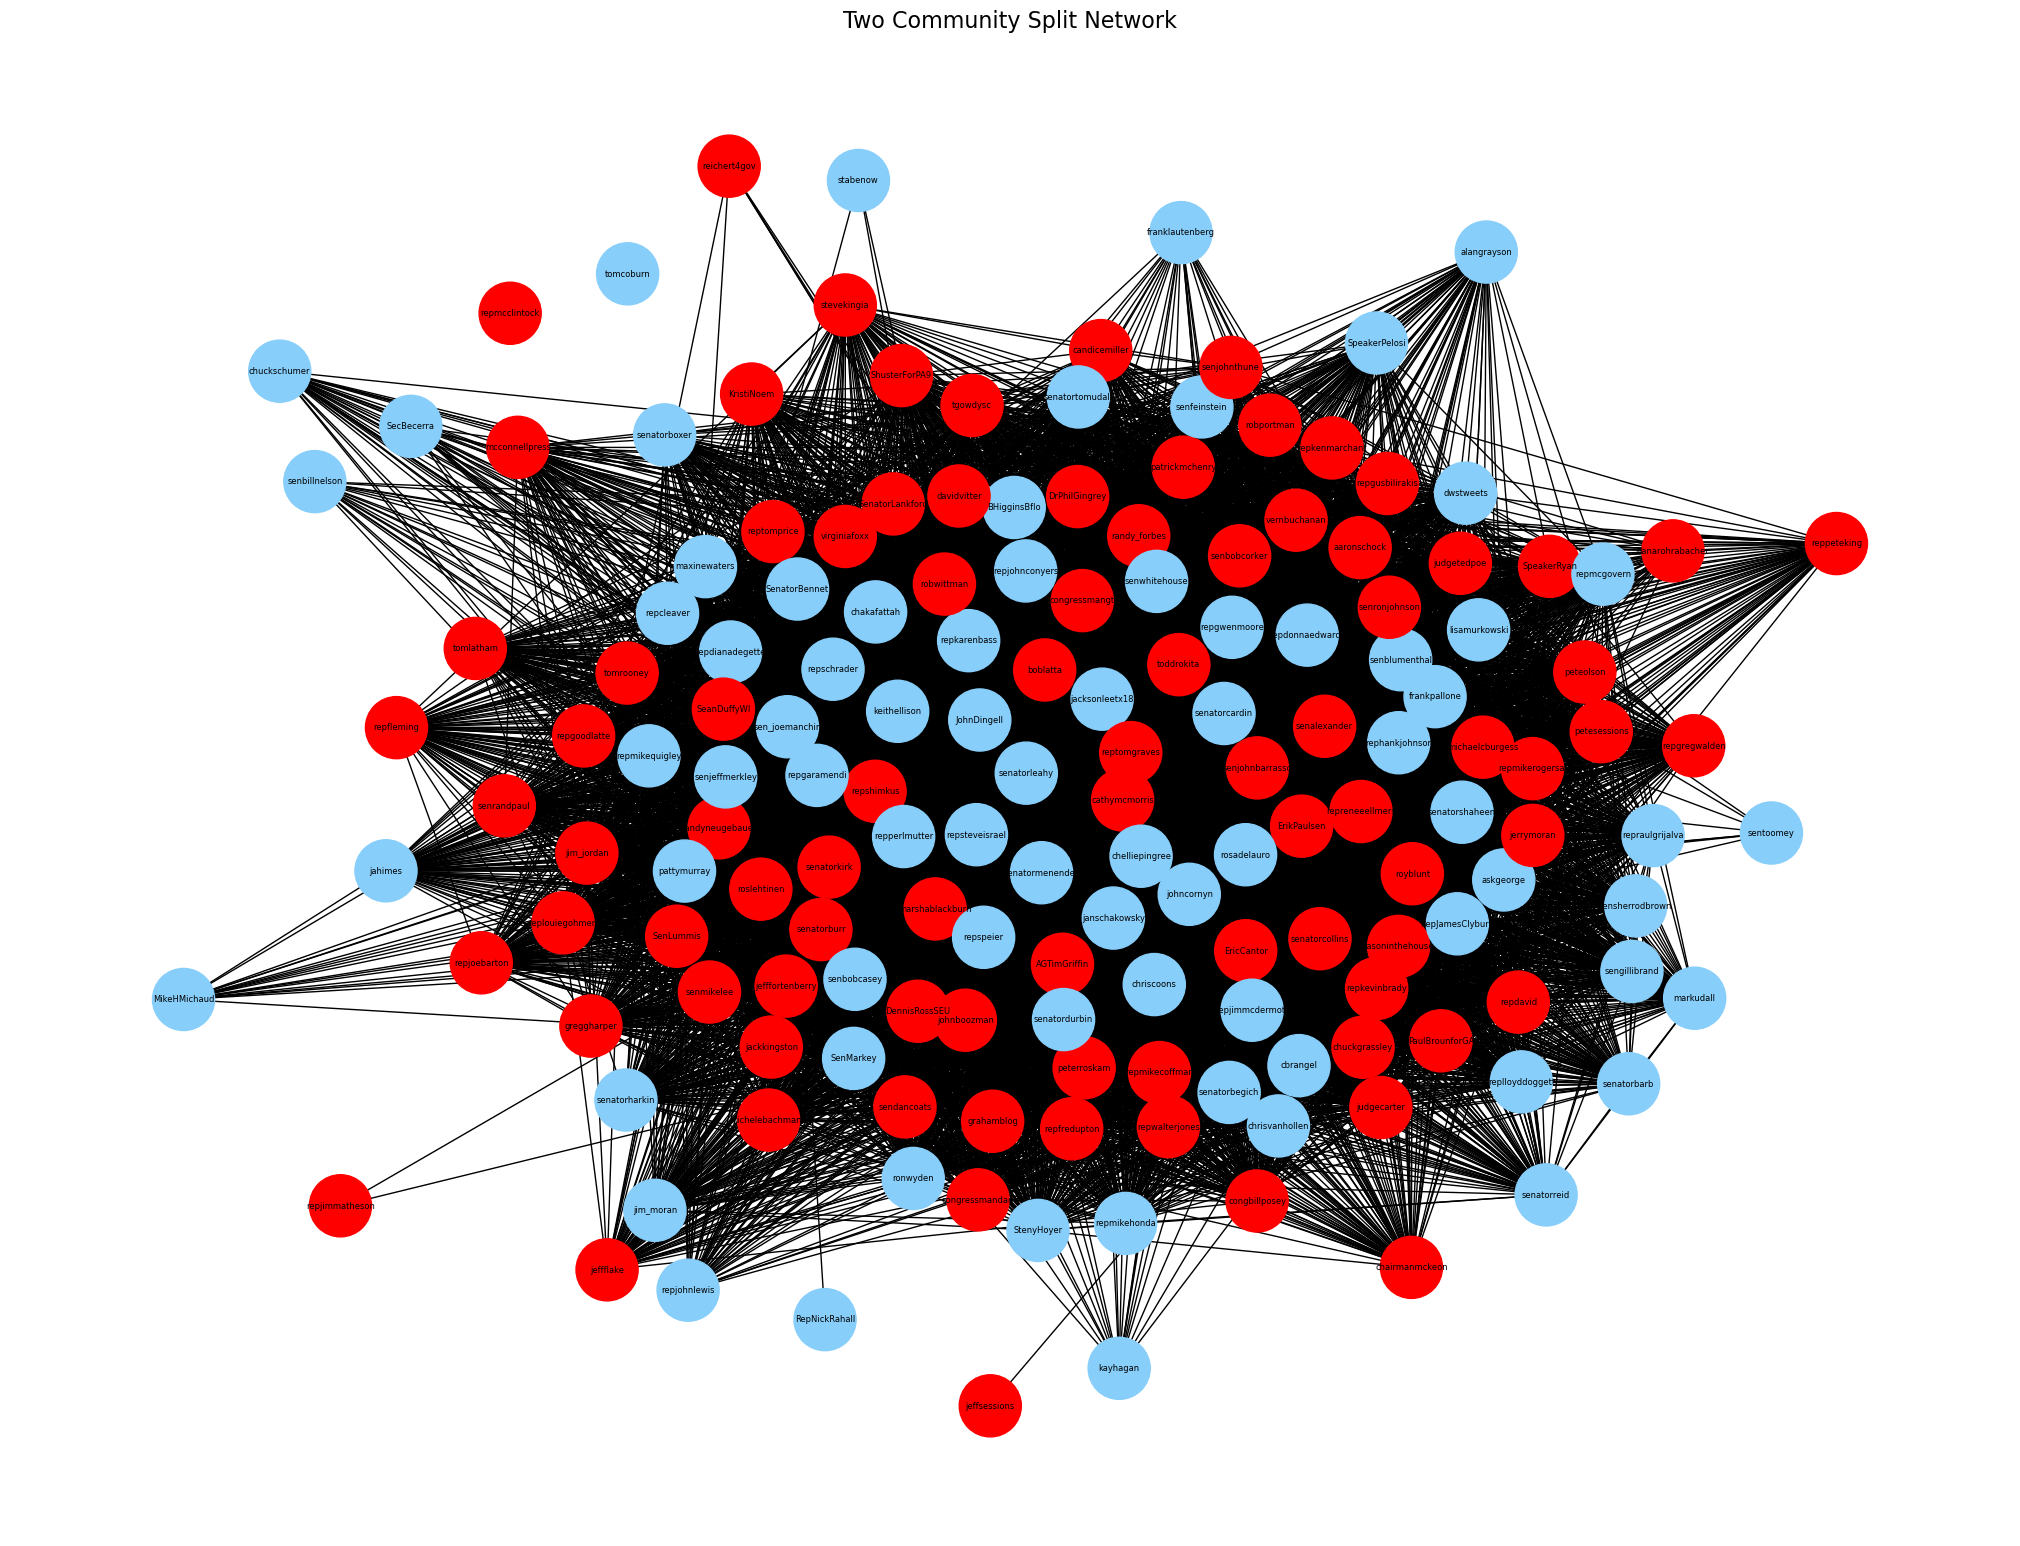

In [308]:
communities, alignment, node_to_comm_louvain = louvain_two_communities(G)
print(alignment)
print(calculate_metrics(alignment, node_to_comm_louvain, G, communities))
title = "Two Community Split Network"
visualise_graph(G, communities, spacing, title)

**With HITS values**

In [309]:
G_directed, authority_scores = build_hits_network_and_store(df_data)

c:\Users\tusha\anaconda3\lib\site-packages\networkx\algorithms\link_analysis\hits_alg.py:78: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G, nodelist=list(G), dtype=float)


In [310]:
""" HITS THRESHOLD PARAMETER """

# hits threshold value (calculated based on the authority scores)
hits_threshold = np.percentile(authority_scores, 70)

Number of nodes: 164
Number of edges: 9853
Degree of each node: [('SpeakerRyan', 84), ('SpeakerPelosi', 93), ('michelebachmann', 124), ('dwstweets', 129), ('EricCantor', 150), ('keithellison', 149), ('alangrayson', 63), ('jasoninthehouse', 142), ('StenyHoyer', 119), ('reptomprice', 141), ('repkarenbass', 140), ('maxinewaters', 121), ('repjohnlewis', 44), ('RepJamesClyburn', 146), ('aaronschock', 134), ('roslehtinen', 144), ('stevekingia', 83), ('cathymcmorris', 149), ('vernbuchanan', 142), ('jim_jordan', 140), ('cbrangel', 145), ('reppeteking', 68), ('danarohrabacher', 30), ('repjoebarton', 101), ('michaelcburgess', 146), ('DrPhilGingrey', 144), ('peterroskam', 145), ('robwittman', 150), ('chairmanmckeon', 88), ('patrickmchenry', 127), ('tomrooney', 139), ('chrisvanhollen', 142), ('KristiNoem', 94), ('repsteveisrael', 151), ('repshimkus', 147), ('randy_forbes', 150), ('PaulBrounforGA', 141), ('repmikehonda', 116), ('virginiafoxx', 139), ('repmikecoffman', 145), ('janschakowsky', 148), 

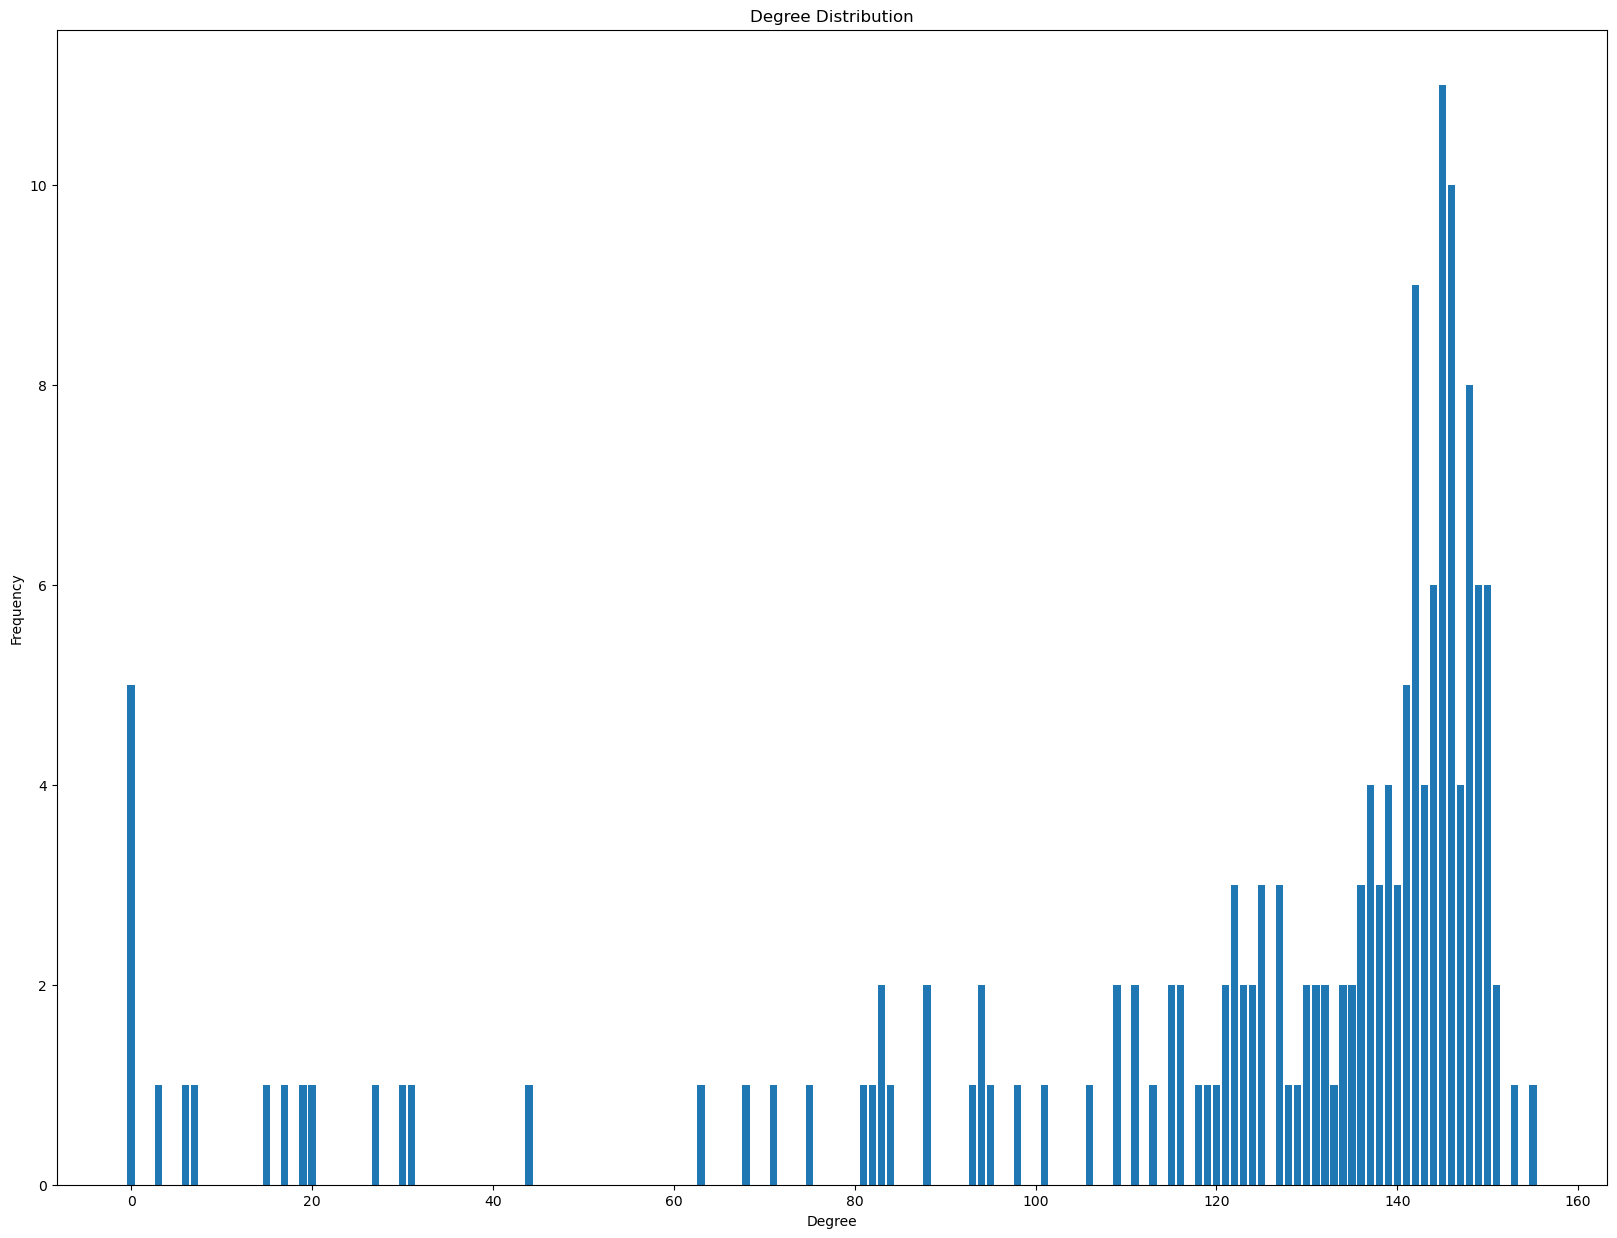

Graph is not connected. Calculating for each connected component...
Component 1: Average Shortest Path Length = 1.2163044343603215
Component 2: Average Shortest Path Length = 0
Component 3: Average Shortest Path Length = 0
Component 4: Average Shortest Path Length = 0
Component 5: Average Shortest Path Length = 0
Component 6: Average Shortest Path Length = 0
Party Assortativity Coefficient: 0.10343968248958586


In [311]:
df_data = add_important_following_column(G_directed, df_data, hits_threshold)
G_hits = build_network(df_data, follow_thresh, True)
graph_info(G_hits)

{1: {'R': 86, 'D': 3}, 2: {'R': 5, 'D': 70}}
{'fcc': 0.9512195121951219, 'ari': 0.8132561810869507, 'ri': 0.9066287595391291, 'nmi': 0.719313862796058, 'precision': 0.949812734082397, 'recall': 0.9519795273219931, 'modularity': 0.05091828978648269, 'coverage': 0.560641429006394, 'performance': 0.5888074218165494, 'conductance': 0.5105554900342022}


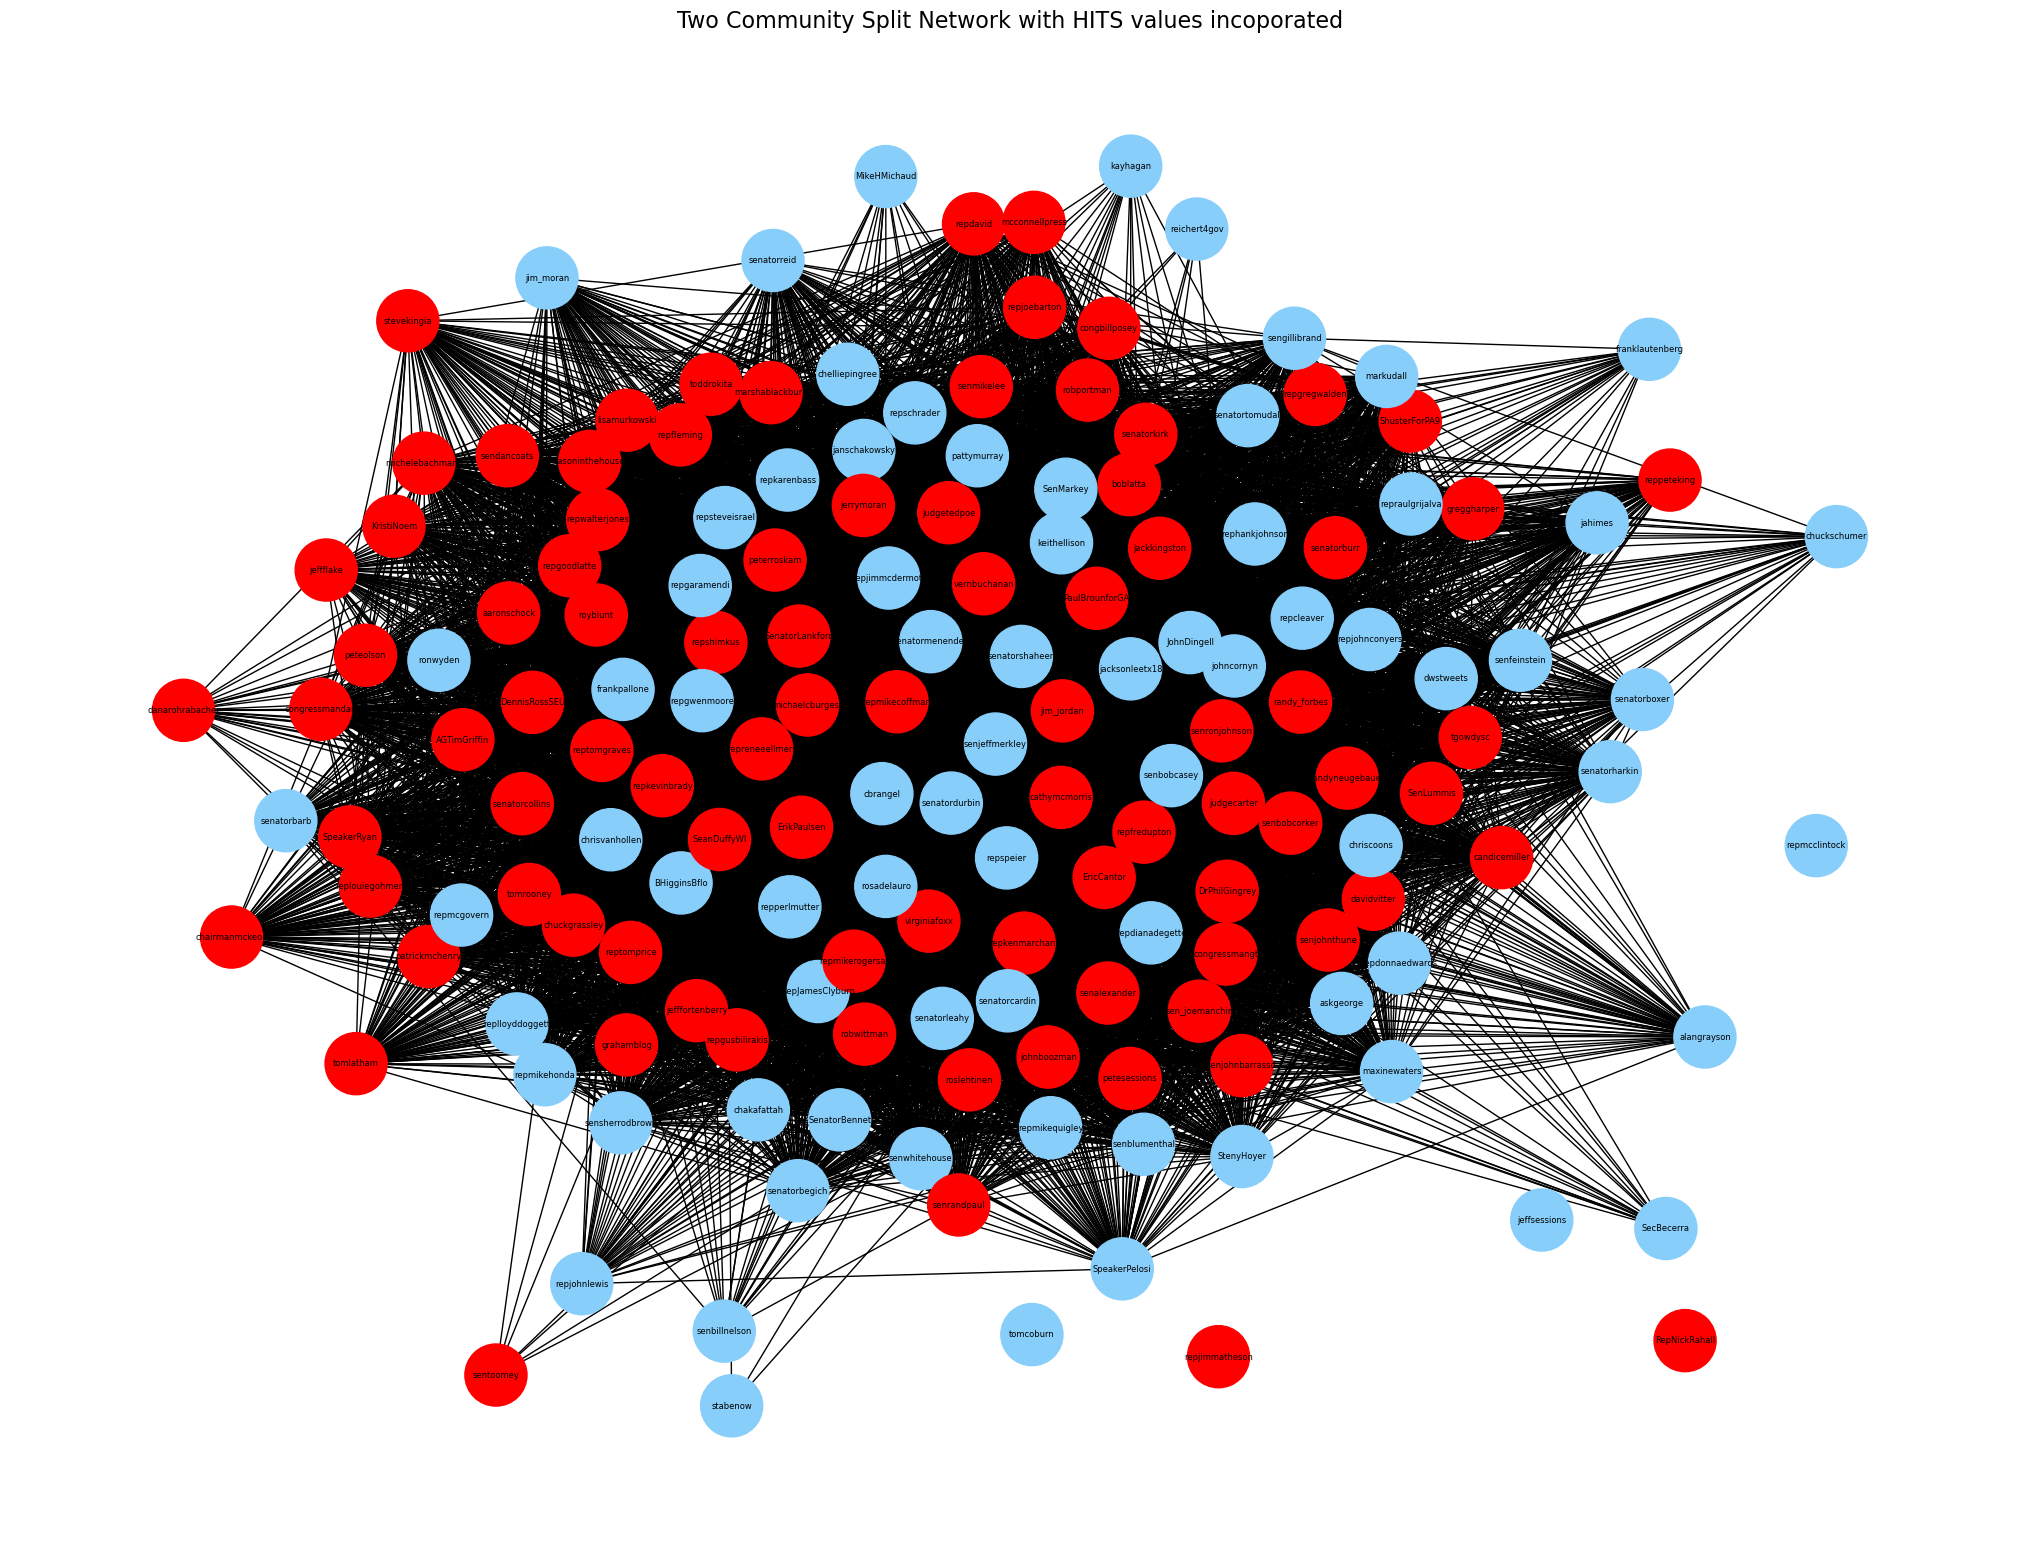

In [312]:
communities, alignment, node_to_comm_louvain = louvain_two_communities(G_hits)
print(alignment)
print(calculate_metrics(alignment, node_to_comm_louvain, G_hits, communities))
title = "Two Community Split Network with HITS values incoporated"
visualise_graph(G_hits, communities, spacing, title)

**Experiments**

In [270]:
def moving_average(data, window_size):
    """
    Apply a moving average to smooth the data.

    Parameters:
        data (list): The list of data points to smooth.
        window_size (int): The size of the moving average window.

    Returns:
        list: Smoothed data.
    """
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

In [271]:
def remove_isolated_nodes(graph):
    # Identify isolated nodes
    isolated_nodes = list(nx.isolates(graph))
    
    # Remove isolated nodes from the graph
    graph.remove_nodes_from(isolated_nodes)
    
    return graph

In [313]:
def analyse_thresholds(df_data, follow_thresh_range, step, hits_threshold_values=[70]):
    """
    Analyze the effect of following_thresh and hits_threshold on alignment metrics.

    Parameters:
        df_data (DataFrame): Data for the network.
        follow_thresh_range (int): Maximum threshold value to analyze.
        step (int): Step size for following_thresh.
        hits_threshold_values (list): Percentile values to experiment with for HITS.

    Returns:
        None: Generates plots for accuracy, precision_macro, recall_macro, and f1_macro.
    """

    conditions = ['Without HITS', 'With HITS']
    results = {"Without HITS": {'fcc': [], 'ari': [], 'ri': [], 'nmi': [], 'precision': [], 'recall': [], 'modularity': [], 'coverage': [], 'performance': [], 'conductance': []}}
    thresholds = range(1, follow_thresh_range, step)
    # max_f1_score = -1
    # best_thresh = -1

    for condition in conditions:
        is_hits = condition == 'With HITS'
        for hits_threshold in (hits_threshold_values if is_hits else [None]):  # Only iterate hits_threshold for HITS case
            print(f"Experimenting with {condition} (HITS Threshold: {hits_threshold})")
            results_key = f"{condition} (HITS = {hits_threshold} percentile threshold)" if is_hits else condition
            results[results_key] = {'fcc': [], 'ari': [], 'ri': [], 'nmi': [], 'precision': [], 'recall': [], 'modularity': [], 'coverage': [], 'performance': [], 'conductance': []}

            for follow_thresh in thresholds:
                if is_hits:
                    G_directed, authority_scores = build_hits_network_and_store(df_data)
                    hits_threshold_value = np.percentile(authority_scores, hits_threshold)
                    df_data = add_important_following_column(G_directed, df_data, hits_threshold_value)
                    G_hits = build_network(df_data, follow_thresh, True)
                    communities, alignment, node_to_comm_louvain = louvain_two_communities(G_hits)
                    metrics = calculate_metrics(alignment, node_to_comm_louvain, G_hits, communities)
                else:
                    G = build_network(df_data, follow_thresh, False)
                    communities, alignment, node_to_comm_louvain = louvain_two_communities(G)
                    metrics = calculate_metrics(alignment, node_to_comm_louvain, G, communities)

                # Calculate metrics
                # metrics = calculate_metrics(alignment, node_to_comm_louvain, G, communities)
                # if metrics["fcc"] > max_f1_score:
                #     max_f1_score = metrics["fcc"]
                #     best_thresh = follow_thresh
                #     print("hello", )

                # Append metrics for the current condition
                results[results_key]['fcc'].append(metrics["fcc"])
                results[results_key]['ari'].append(metrics["ari"])
                results[results_key]['ri'].append(metrics["ri"])
                results[results_key]['nmi'].append(metrics["nmi"])
                results[results_key]['precision'].append(metrics["precision"])
                results[results_key]['recall'].append(metrics["recall"])
                results[results_key]['modularity'].append(metrics["modularity"])
                results[results_key]['coverage'].append(metrics["coverage"])
                results[results_key]['performance'].append(metrics["performance"])
                results[results_key]['conductance'].append(metrics["conductance"])

    # Plot metrics for both conditions    
    # print("Best Threshold:", best_thresh, "with F1 Score:", max_f1_score)
    font = {'size': 20}
    plt.rc('font', **font)
    print(results)
    for metric in ['fcc', 'ari', 'ri', 'nmi', 'precision', 'recall', 'modularity', 'coverage', 'performance', 'conductance']:
        plt.figure(figsize=(20, 15))
        i = 0
        for results_key in results.keys():
            linestyles = ['-', '--', '-.', ':']
            # smoothed_data = moving_average(results[results_key][metric], window_size=5)  # Adjust window size as needed
            # smoothed_thresholds = thresholds[:len(smoothed_data)]
            plt.plot(thresholds, results[results_key][metric], label=results_key, linestyle=linestyles[i%len(linestyles)])
            # plt.plot(smoothed_thresholds, smoothed_data, label=results_key, linestyle=linestyles[i%len(linestyles)])
            i+=1
        plt.xlabel('Threshold')
        plt.ylabel('Score')
        plt.title(f'{metric.capitalize()} vs. Threshold')
        plt.legend()
        plt.show()


In [314]:
def analyse_thresholds_iso(df_data, follow_thresh_range, step, hits_threshold_values=[70]):
    """
    Analyze the effect of following_thresh and hits_threshold on alignment metrics.

    Parameters:
        df_data (DataFrame): Data for the network.
        follow_thresh_range (int): Maximum threshold value to analyze.
        step (int): Step size for following_thresh.
        hits_threshold_values (list): Percentile values to experiment with for HITS.

    Returns:
        None: Generates plots for accuracy, precision_macro, recall_macro, and f1_macro.
    """

    conditions = ['Without HITS without isolated nodes', 'With HITS without isolated nodes']
    results = {"Without HITS without isolated nodes": {'fcc': [], 'ari': [], 'ri': [], 'nmi': [], 'precision': [], 'recall': [], 'modularity': [], 'coverage': [], 'performance': [], 'conductance': [], 'number of nodes':[]}}
    thresholds = range(1, follow_thresh_range, step)
    # max_f1_score = -1
    # best_thresh = -1

    for condition in conditions:
        is_hits = condition == 'With HITS without isolated nodes'
        for hits_threshold in (hits_threshold_values if is_hits else [None]):  # Only iterate hits_threshold for HITS case
            print(f"Experimenting with {condition} (HITS Threshold: {hits_threshold})")
            results_key = f"{condition} (HITS = {hits_threshold} percentile threshold)" if is_hits else condition
            results[results_key] = {'fcc': [], 'ari': [], 'ri': [], 'nmi': [], 'precision': [], 'recall': [], 'modularity': [], 'coverage': [], 'performance': [], 'conductance': [], 'number of nodes':[]}

            for follow_thresh in thresholds:
                if is_hits:
                    G_directed, authority_scores = build_hits_network_and_store(df_data)
                    hits_threshold_value = np.percentile(authority_scores, hits_threshold)
                    df_data = add_important_following_column(G_directed, df_data, hits_threshold_value)
                    G_hits = build_network(df_data, follow_thresh, True)
                    G_iso = remove_isolated_nodes(G_hits)
                    communities, alignment, node_to_comm_louvain = louvain_two_communities(G_iso)
                    metrics = calculate_metrics(alignment, node_to_comm_louvain, G_iso, communities)
                else:
                    G = build_network(df_data, follow_thresh, False)
                    G_iso = remove_isolated_nodes(G)
                    communities, alignment, node_to_comm_louvain = louvain_two_communities(G_iso)
                    metrics = calculate_metrics(alignment, node_to_comm_louvain, G_iso, communities)

                # Calculate metrics
                # metrics = calculate_metrics(alignment, node_to_comm_louvain, G, communities)
                # if metrics["fcc"] > max_f1_score:
                #     max_f1_score = metrics["fcc"]
                #     best_thresh = follow_thresh
                #     print("hello", )

                # Append metrics for the current condition
                results[results_key]['fcc'].append(metrics["fcc"])
                results[results_key]['ari'].append(metrics["ari"])
                results[results_key]['ri'].append(metrics["ri"])
                results[results_key]['nmi'].append(metrics["nmi"])
                results[results_key]['precision'].append(metrics["precision"])
                results[results_key]['recall'].append(metrics["recall"])
                results[results_key]['modularity'].append(metrics["modularity"])
                results[results_key]['coverage'].append(metrics["coverage"])
                results[results_key]['performance'].append(metrics["performance"])
                results[results_key]['conductance'].append(metrics["conductance"])
                results[results_key]['number of nodes'].append(G_iso.number_of_nodes())

    # Plot metrics for both conditions    
    # print("Best Threshold:", best_thresh, "with F1 Score:", max_f1_score)
    font = {'size': 20}
    plt.rc('font', **font)
    print(results)
    for metric in ['fcc', 'ari', 'ri', 'nmi', 'precision', 'recall', 'modularity', 'coverage', 'performance', 'conductance', 'number of nodes']:
        plt.figure(figsize=(20, 15))
        i = 0
        for results_key in results.keys():
            linestyles = ['-', '--', '-.', ':']
            # smoothed_data = moving_average(results[results_key][metric], window_size=5)  # Adjust window size as needed
            # smoothed_thresholds = thresholds[:len(smoothed_data)]
            plt.plot(thresholds, results[results_key][metric], label=results_key, linestyle=linestyles[i%len(linestyles)])
            # plt.plot(smoothed_thresholds, smoothed_data, label=results_key, linestyle=linestyles[i%len(linestyles)])
            i+=1
        plt.xlabel('Threshold')
        plt.ylabel('Score')
        plt.title(f'{metric.capitalize()} vs. Threshold')
        plt.legend()
        plt.show()


Experimenting with Without HITS (HITS Threshold: None)
Experimenting with With HITS (HITS Threshold: 70)


c:\Users\tusha\anaconda3\lib\site-packages\networkx\algorithms\link_analysis\hits_alg.py:78: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G, nodelist=list(G), dtype=float)
c:\Users\tusha\anaconda3\lib\site-packages\networkx\algorithms\link_analysis\hits_alg.py:78: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G, nodelist=list(G), dtype=float)
c:\Users\tusha\anaconda3\lib\site-packages\networkx\algorithms\link_analysis\hits_alg.py:78: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G, nodelist=list(G), dtype=float)
c:\Users\tusha\anaconda3\lib\site-packages\networkx\algorithms\link_analysis\hits_alg.py:78: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G, nodelist=li

{'Without HITS': {'fcc': [0.8597560975609756, 0.9573170731707317, 0.9634146341463414, 0.9695121951219512, 0.9390243902439024, 0.926829268292683, 0.9329268292682927, 0.9451219512195121, 0.926829268292683, 0.9146341463414634, 0.9207317073170732, 0.8780487804878049, 0.8719512195121951, 0.8963414634146342, 0.9024390243902439, 0.8841463414634146, 0.9024390243902439, 0.8902439024390244, 0.8719512195121951, 0.9085365853658537, 0.9085365853658537, 0.8780487804878049, 0.8658536585365854, 0.9024390243902439, 0.8902439024390244, 0.9024390243902439, 0.9024390243902439, 0.9024390243902439, 0.8841463414634146, 0.774390243902439, 0.7621951219512195, 0.7378048780487805, 0.7073170731707317, 0.725609756097561, 0.8475609756097561, 0.7195121951219512, 0.725609756097561, 0.75, 0.8048780487804879, 0.8048780487804879, 0.8048780487804879, 0.7926829268292683, 0.8048780487804879, 0.823170731707317, 0.823170731707317, 0.823170731707317, 0.774390243902439, 0.8109756097560976, 0.8109756097560976, 0.762195121951219

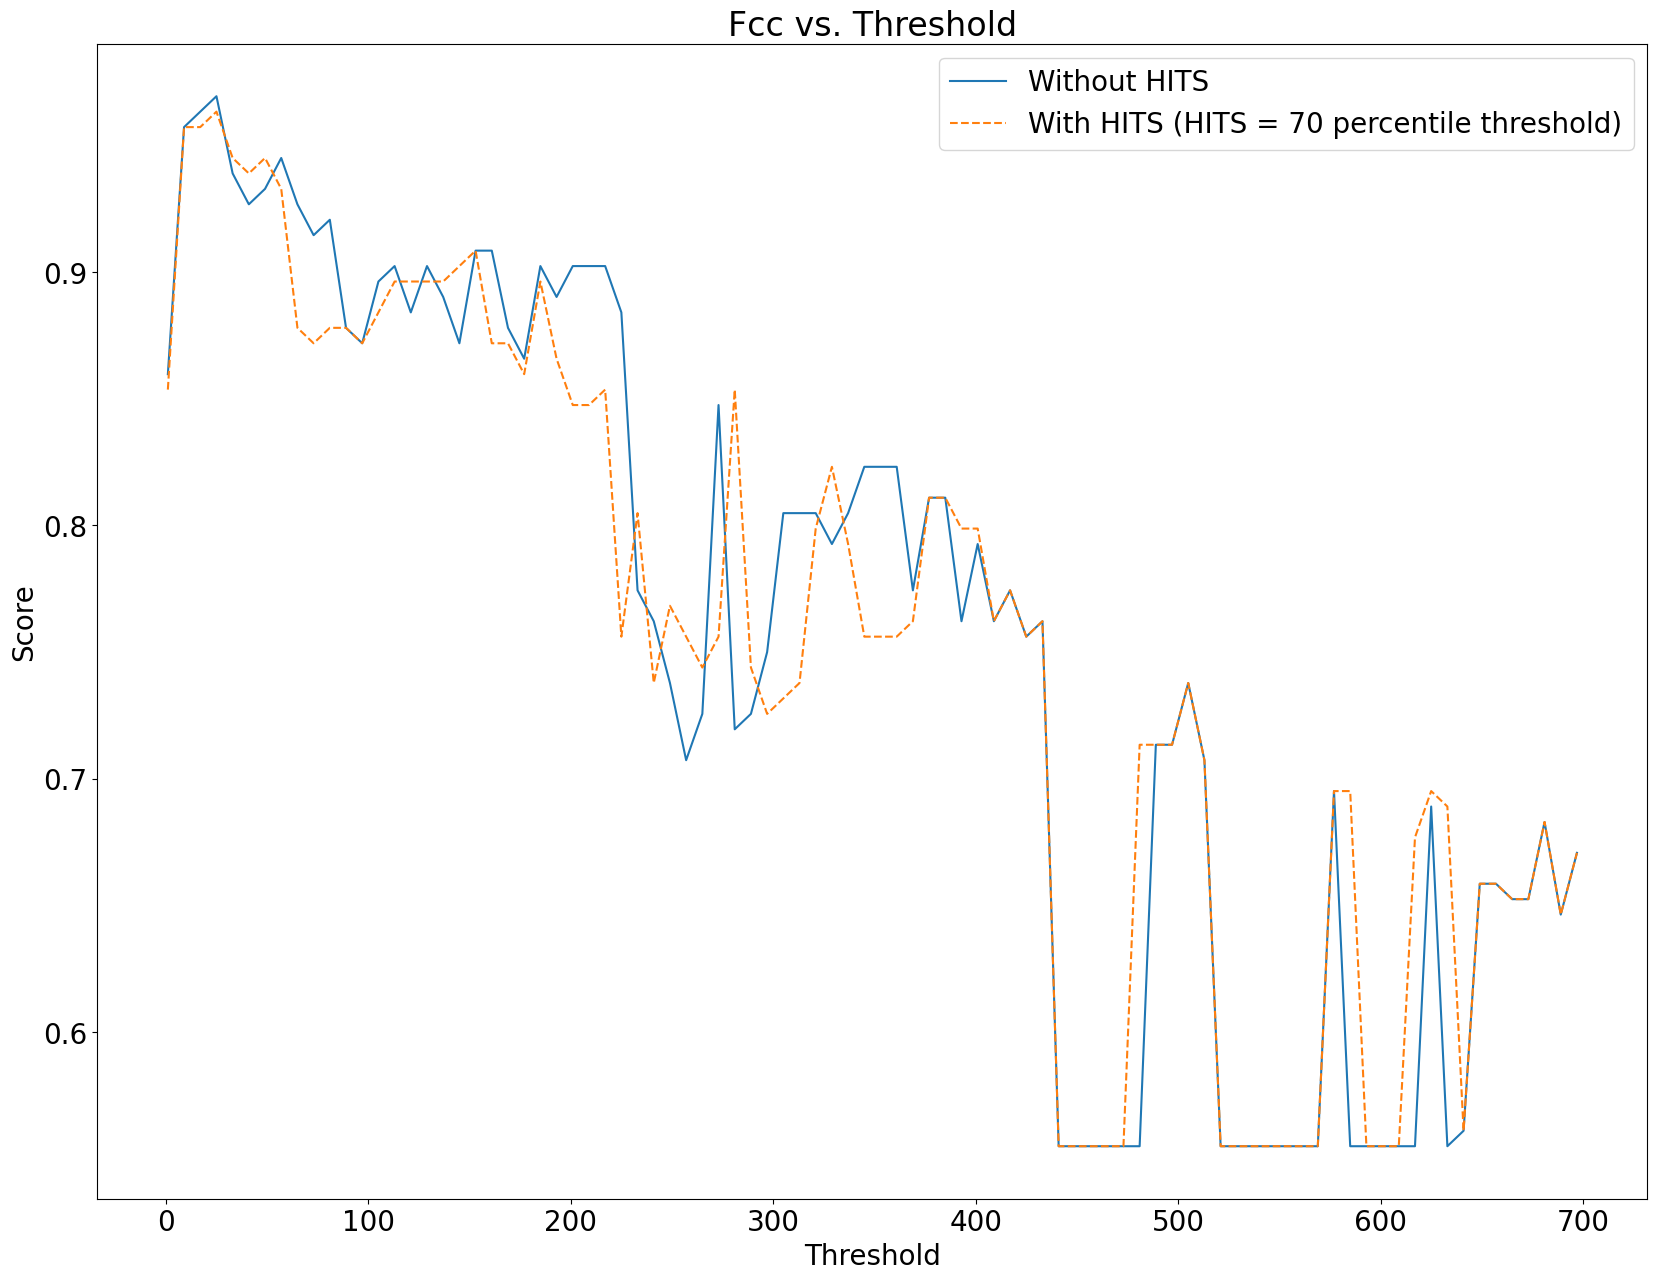

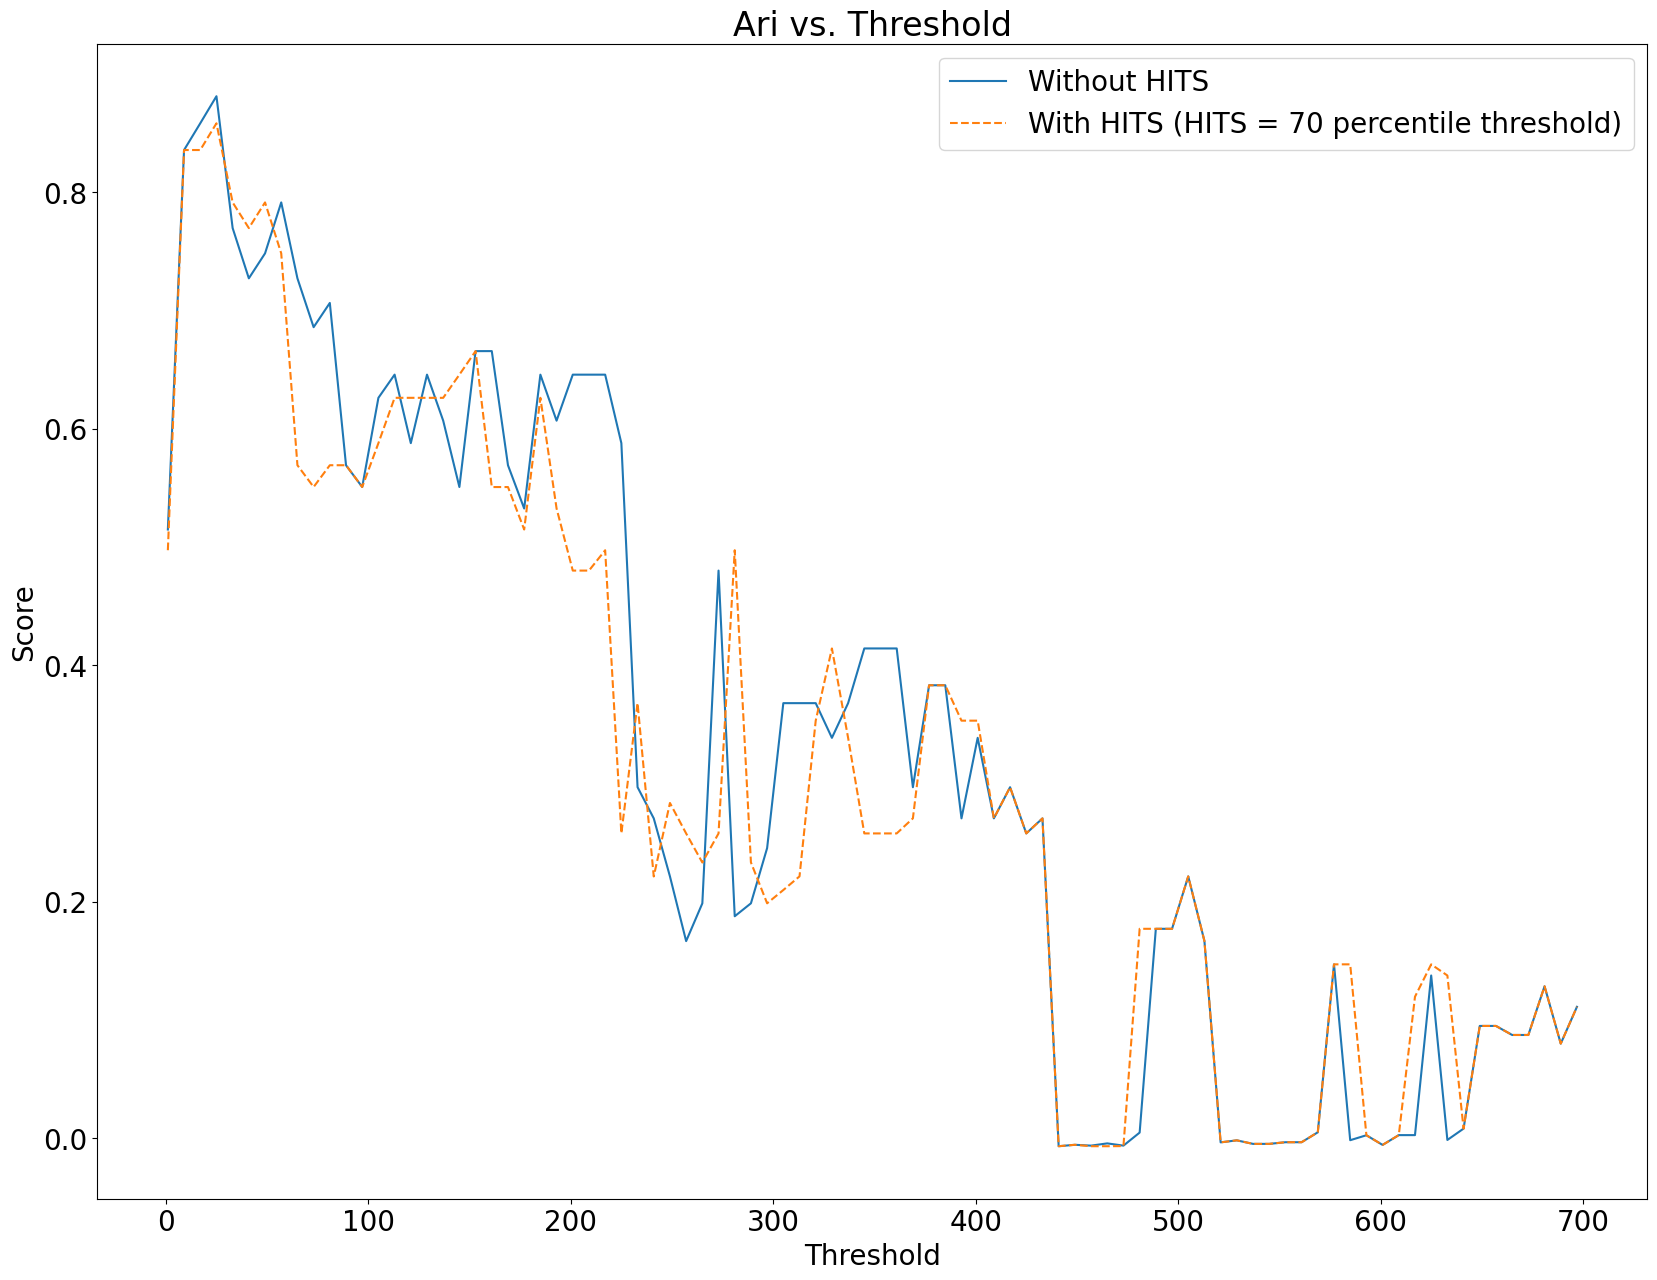

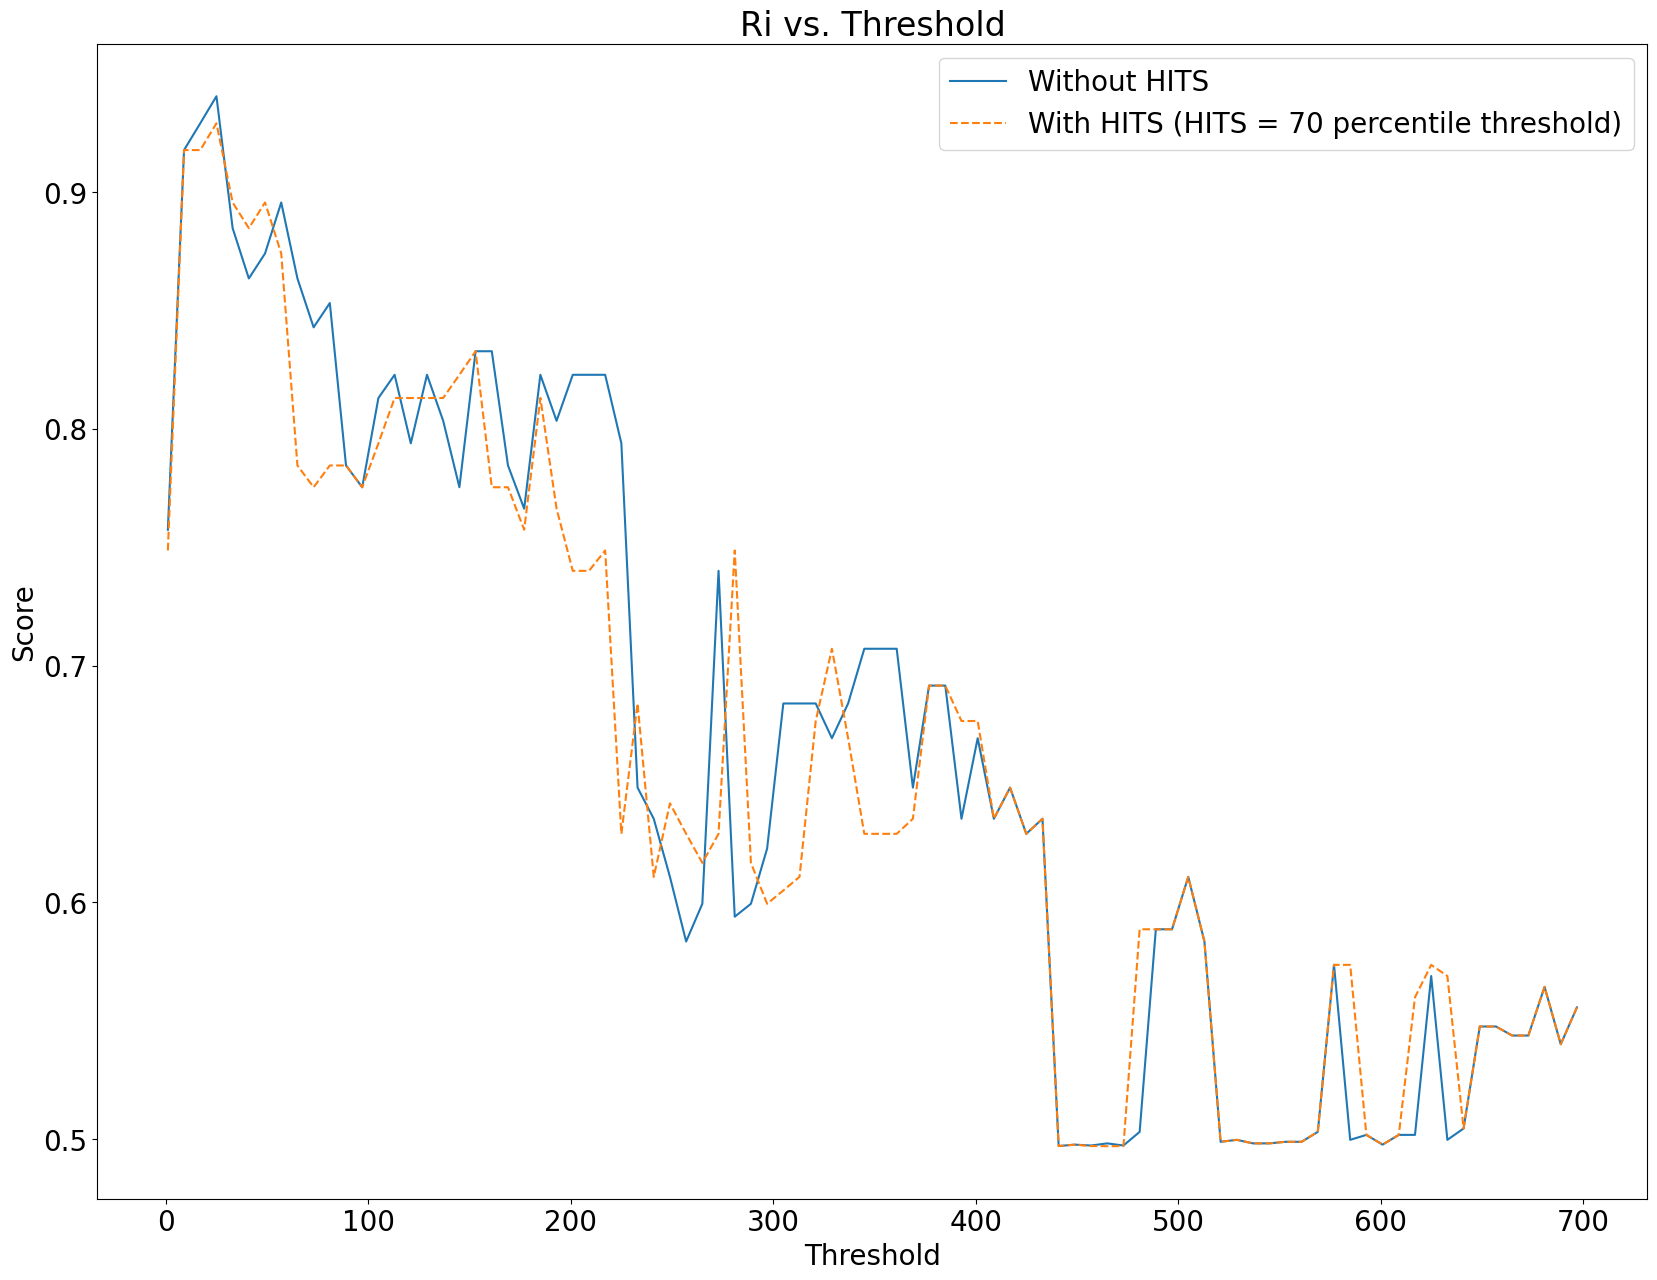

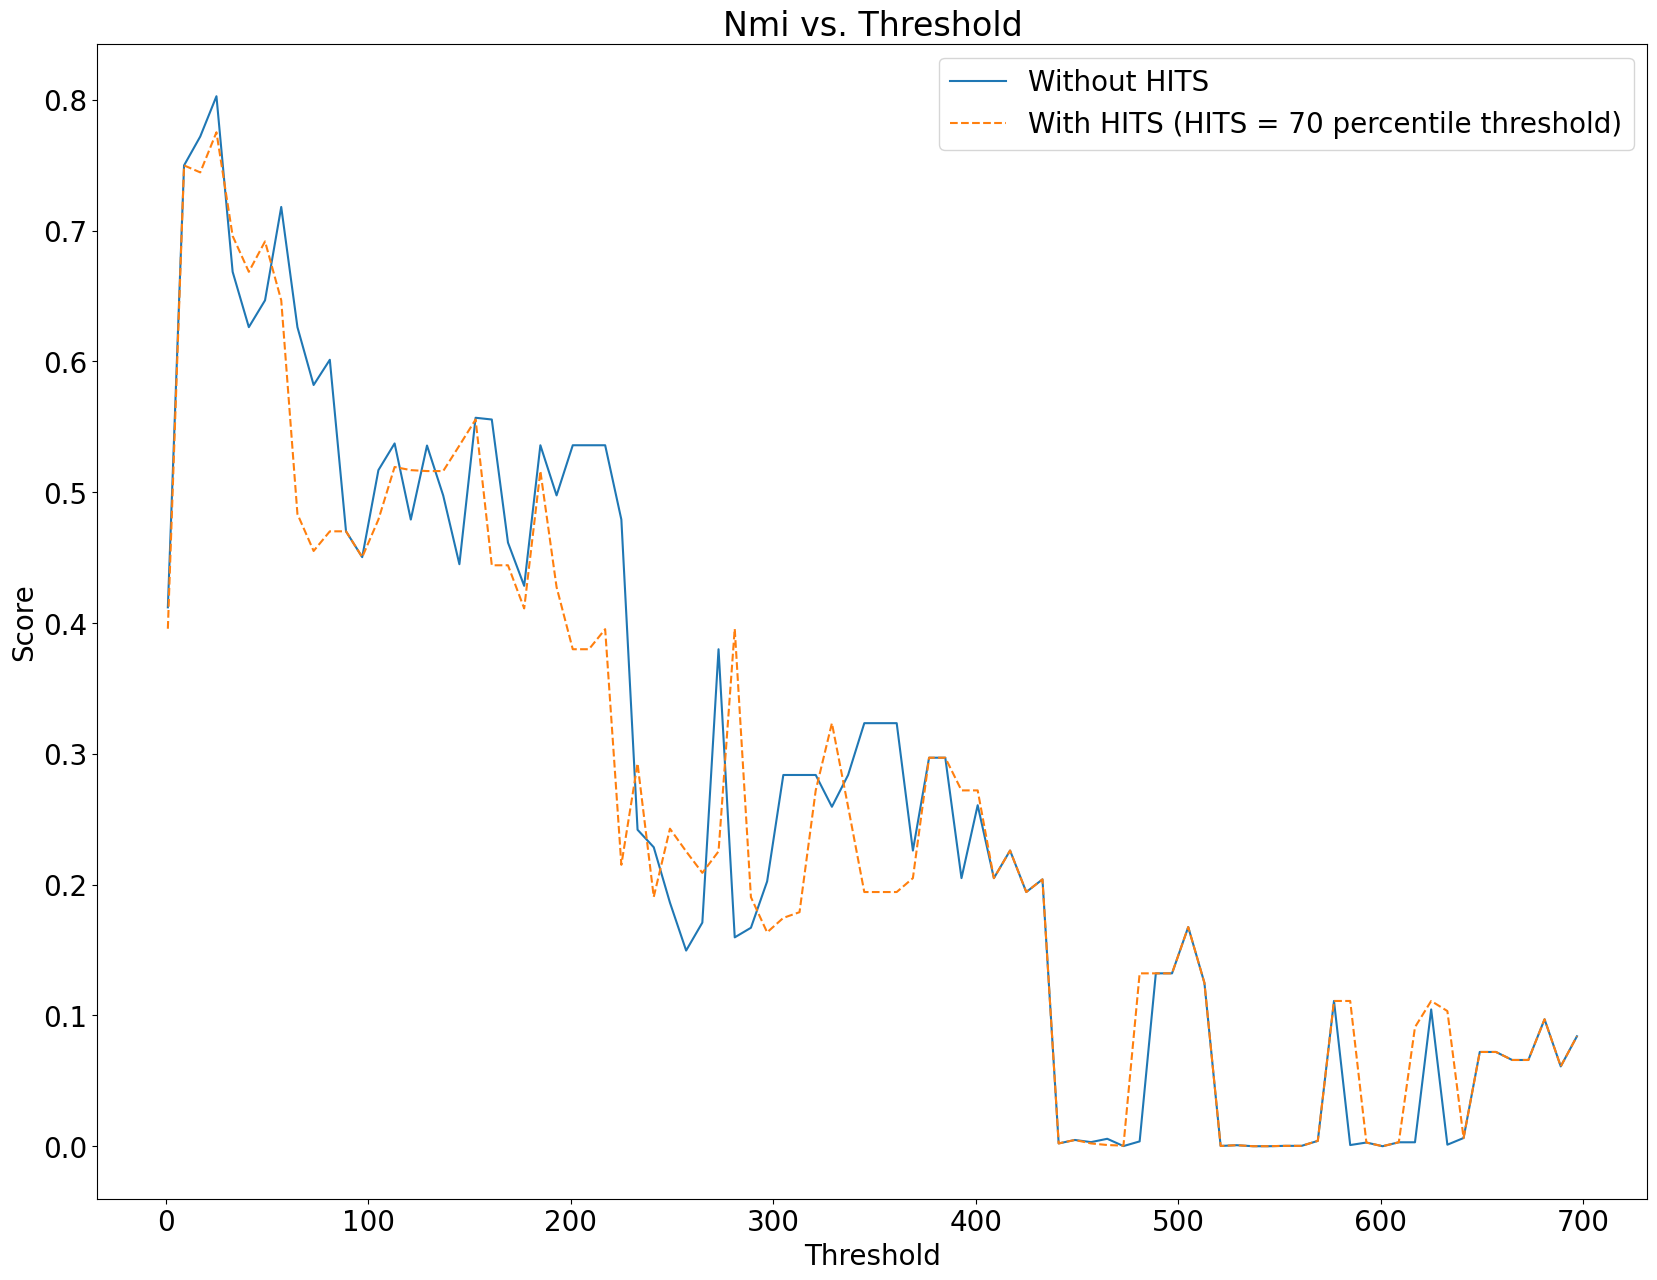

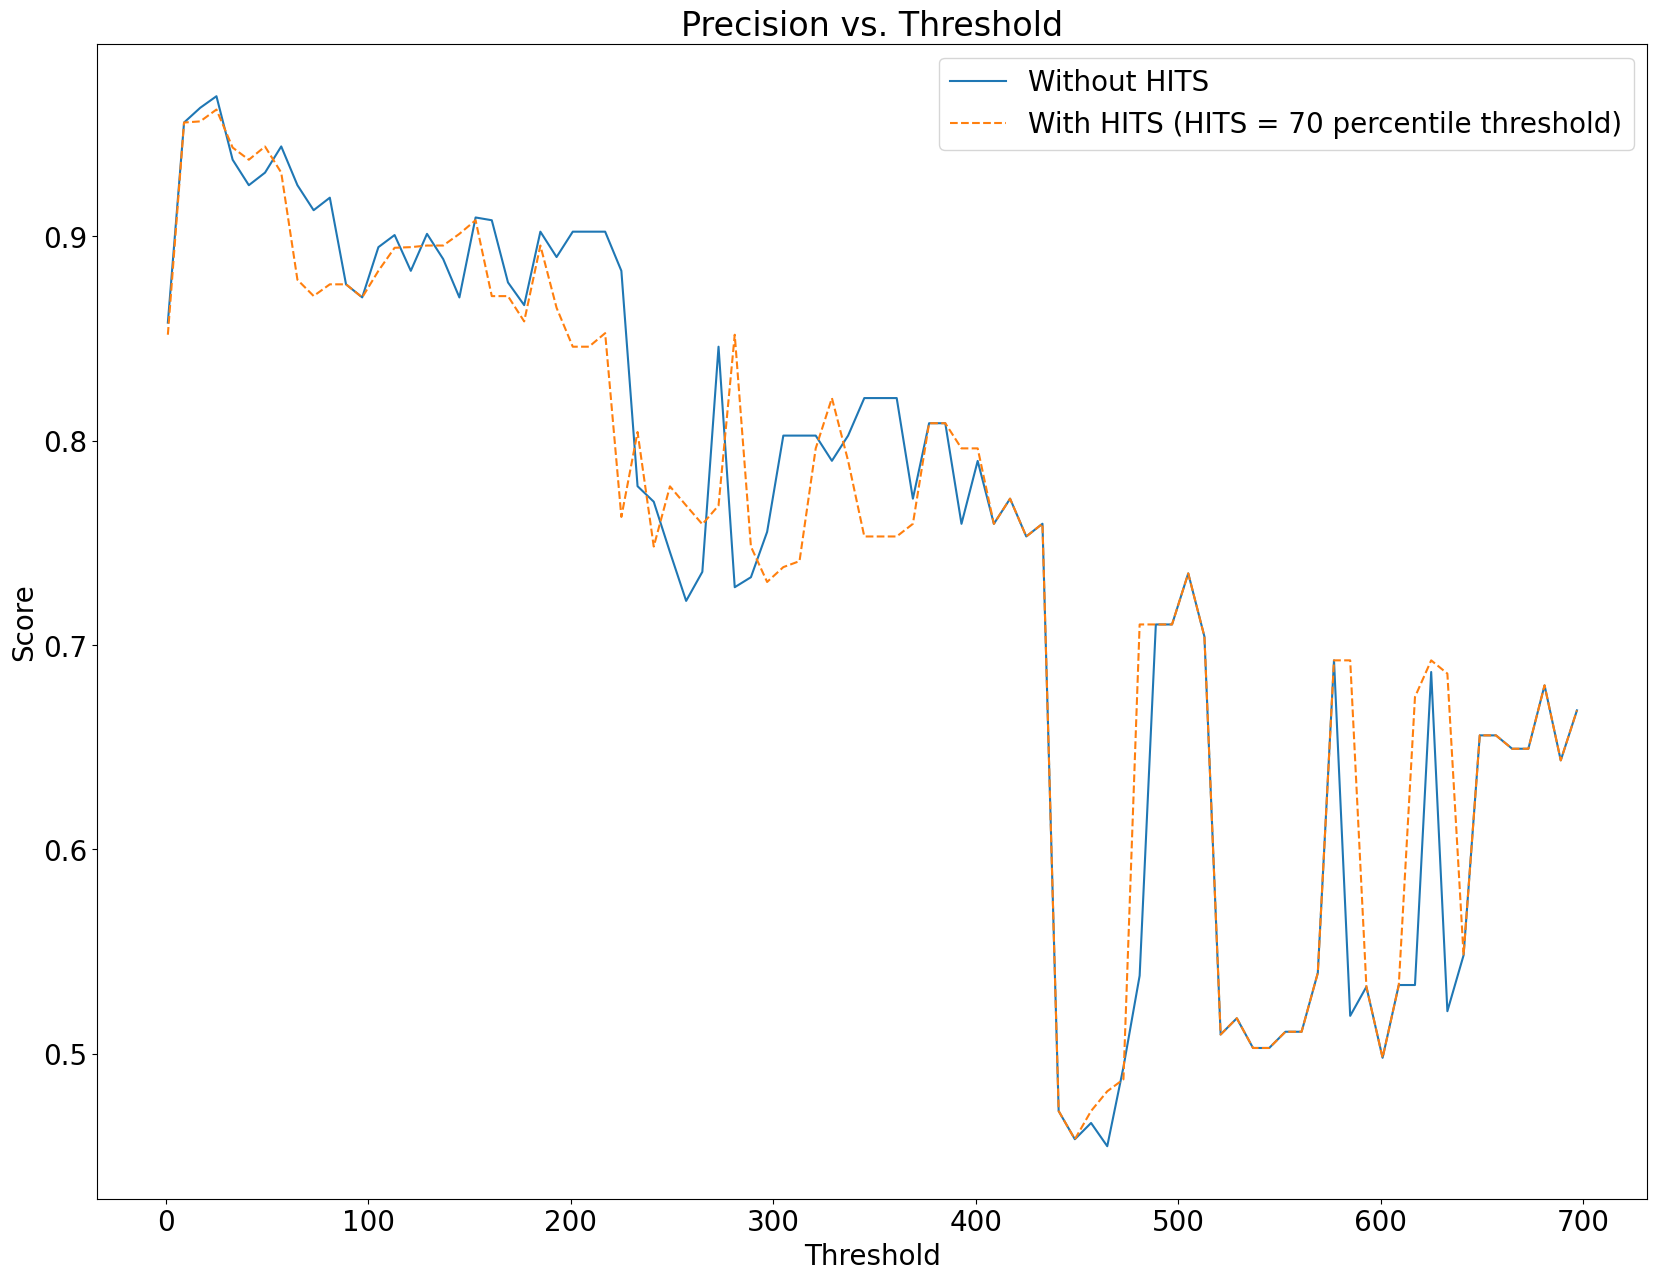

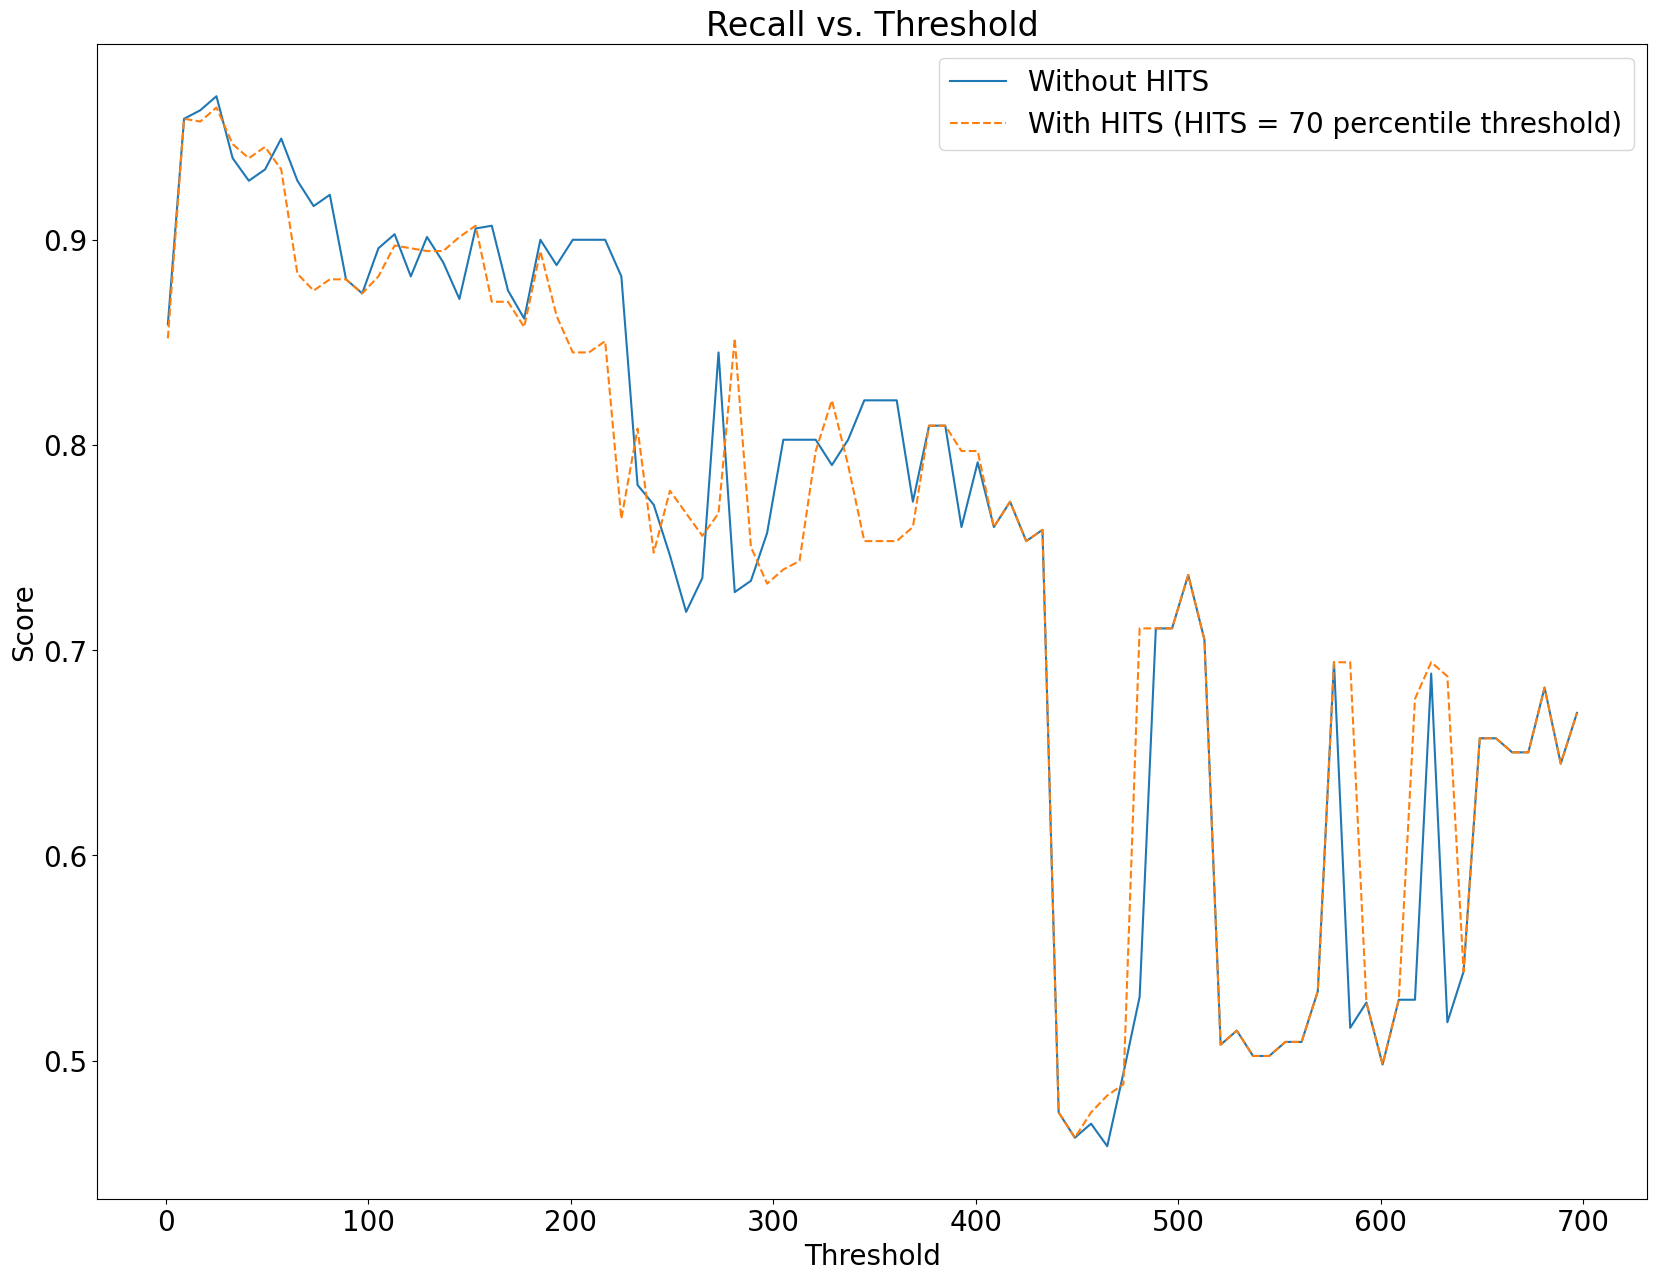

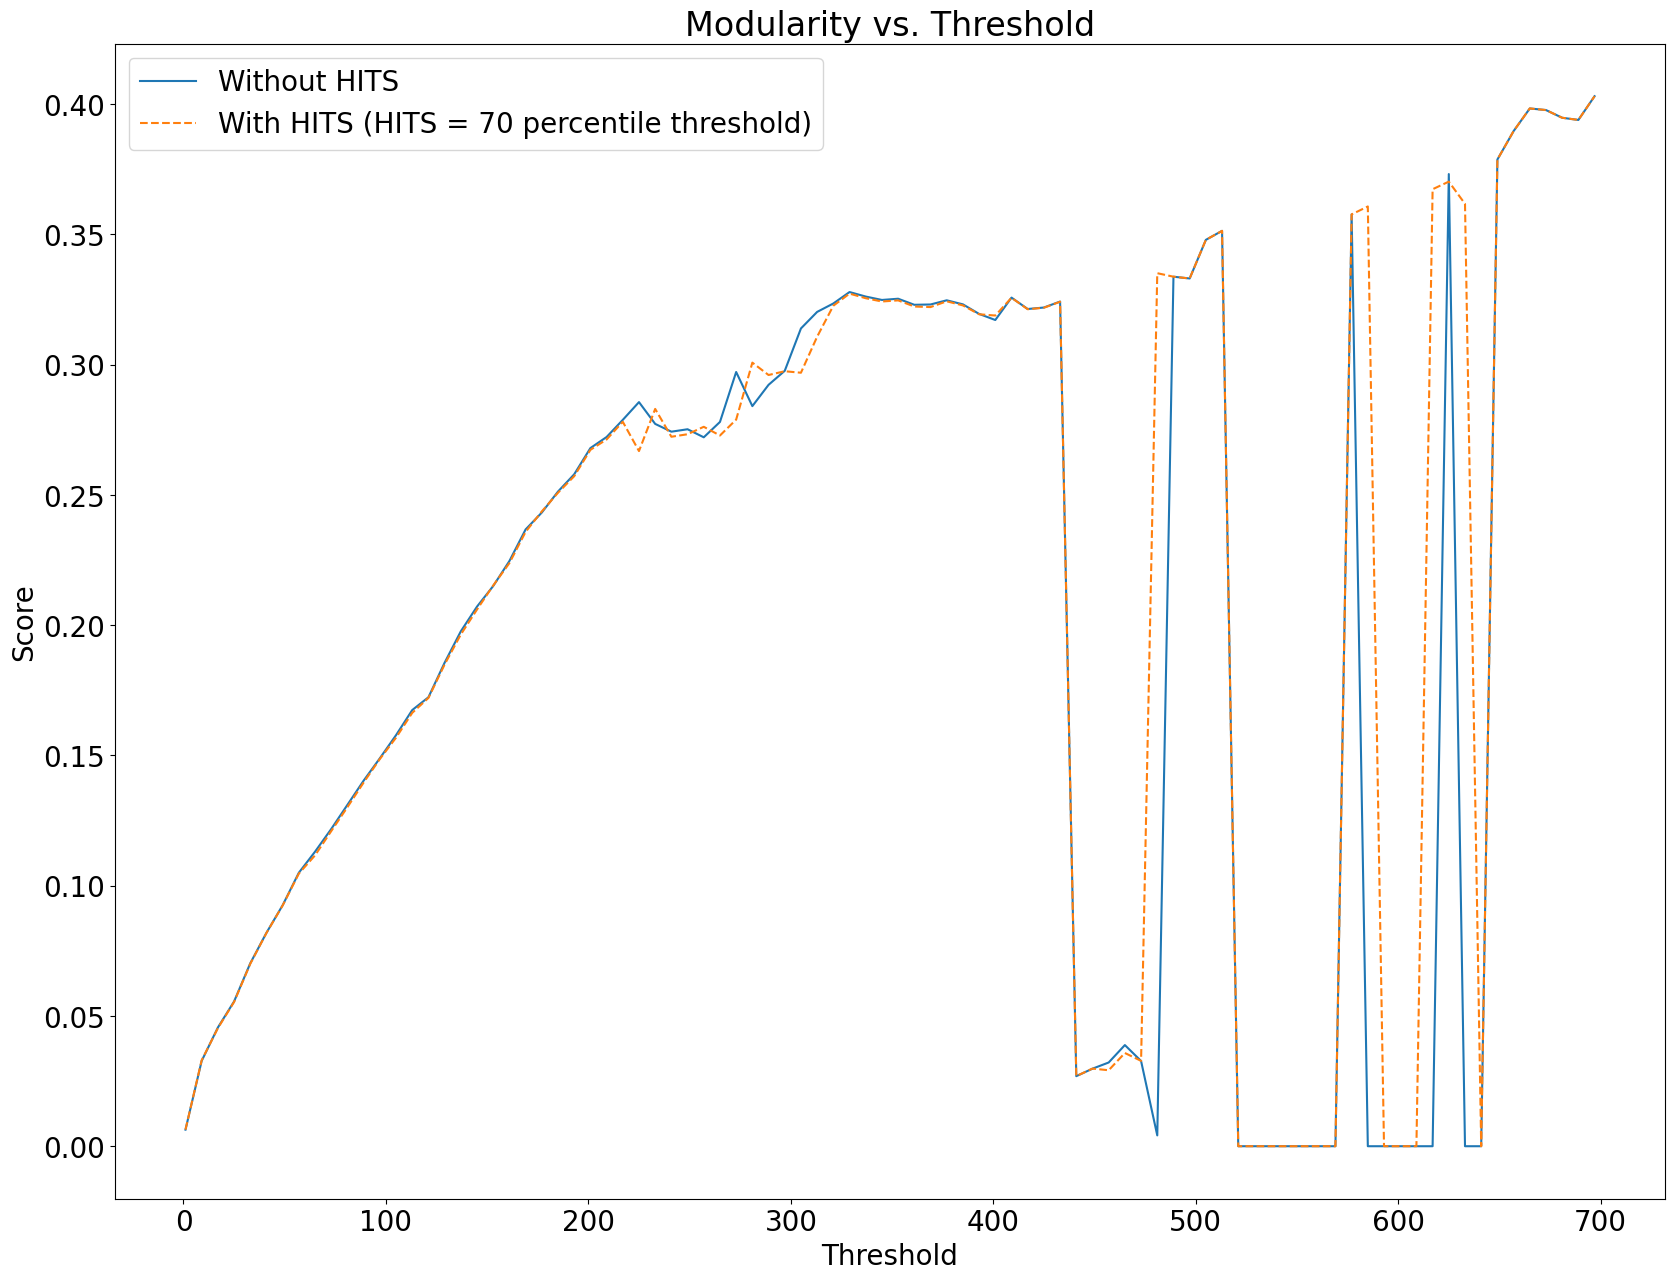

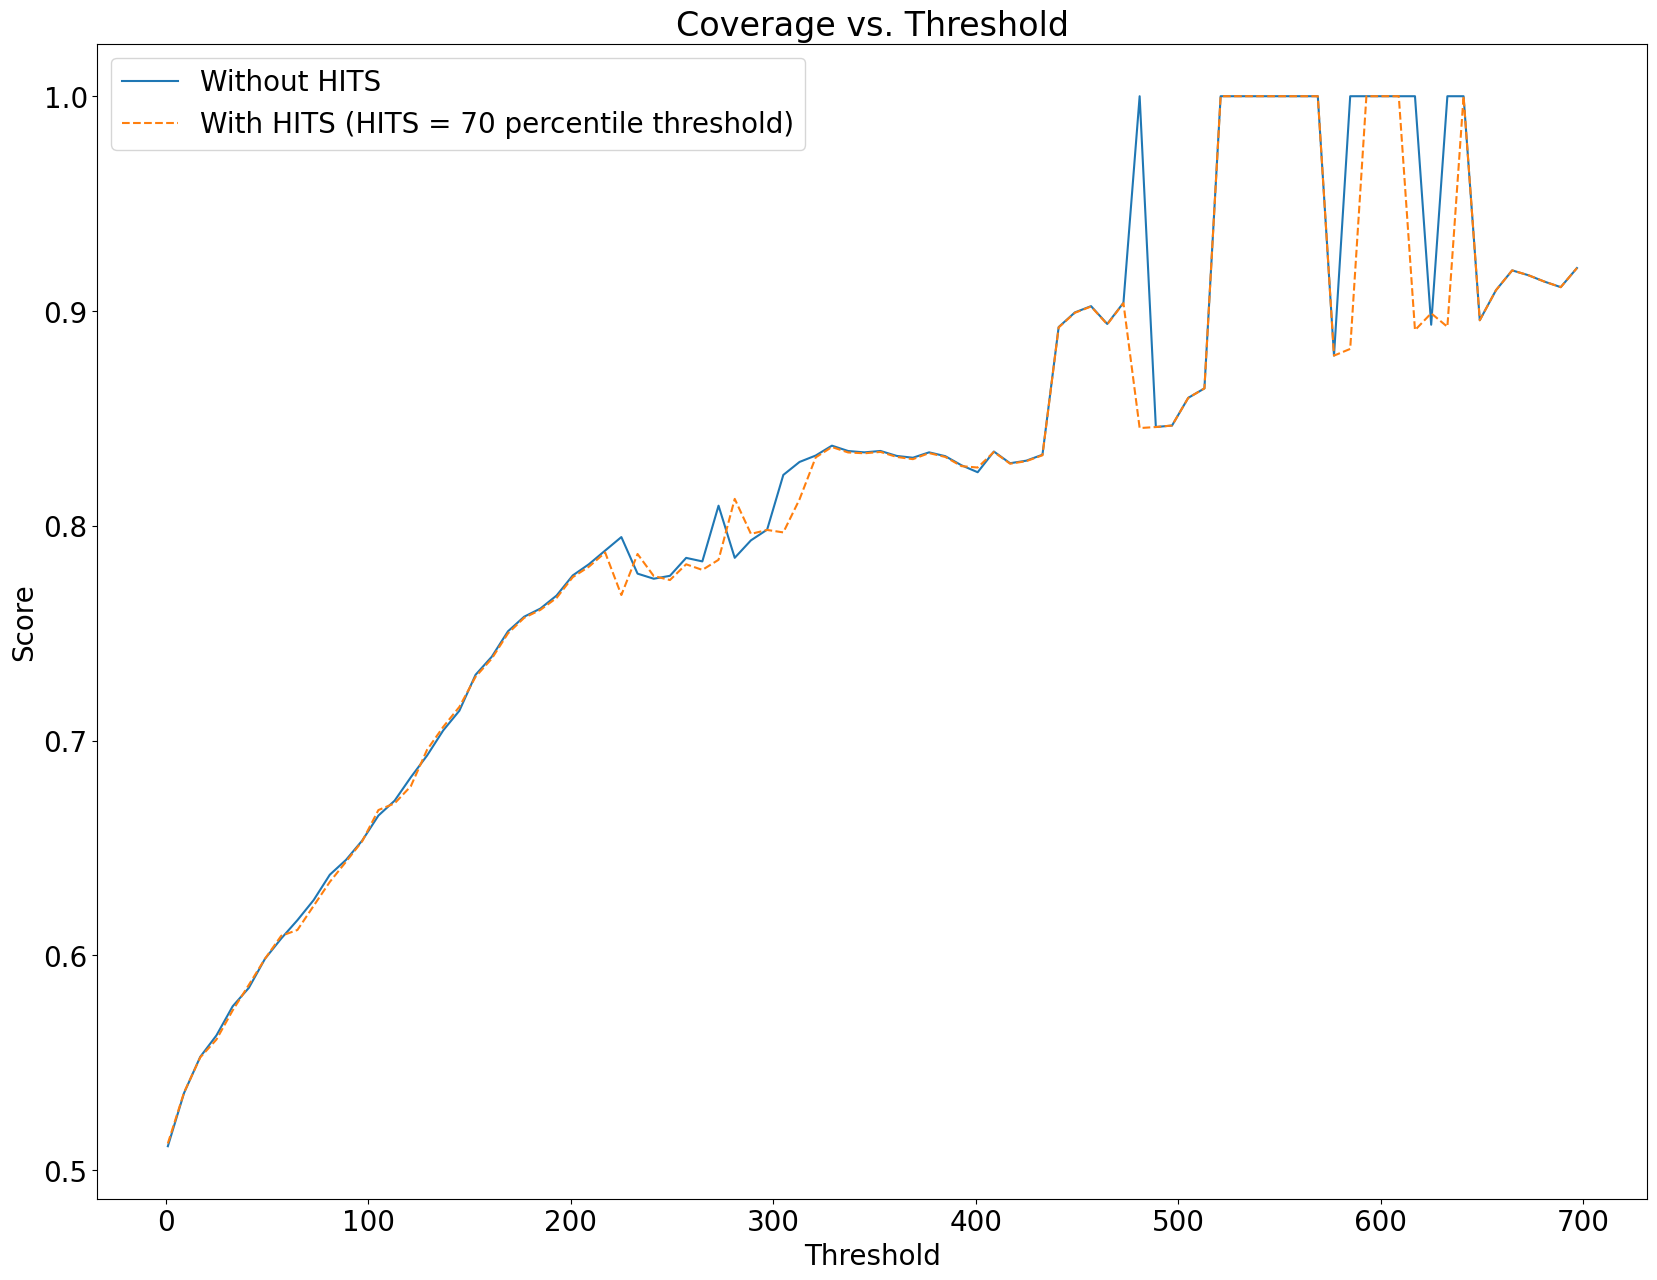

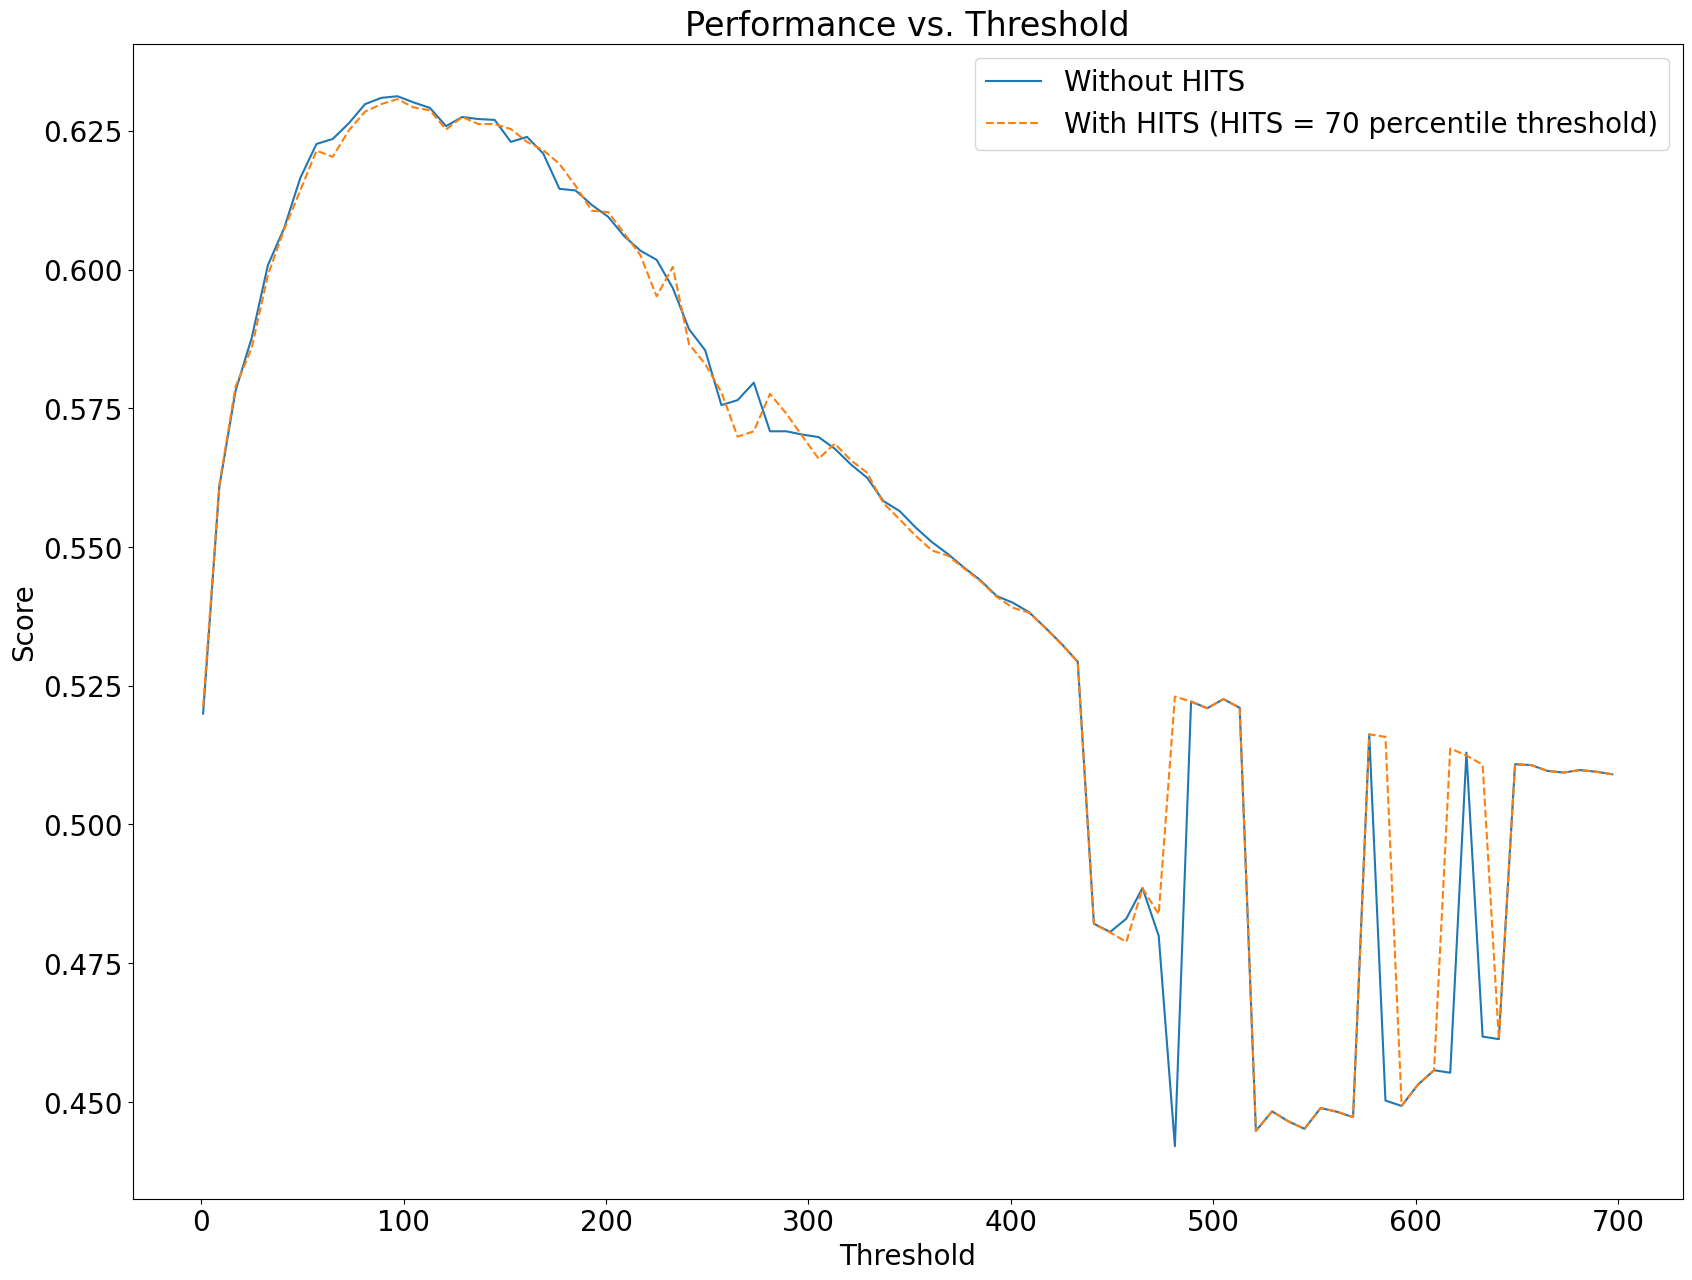

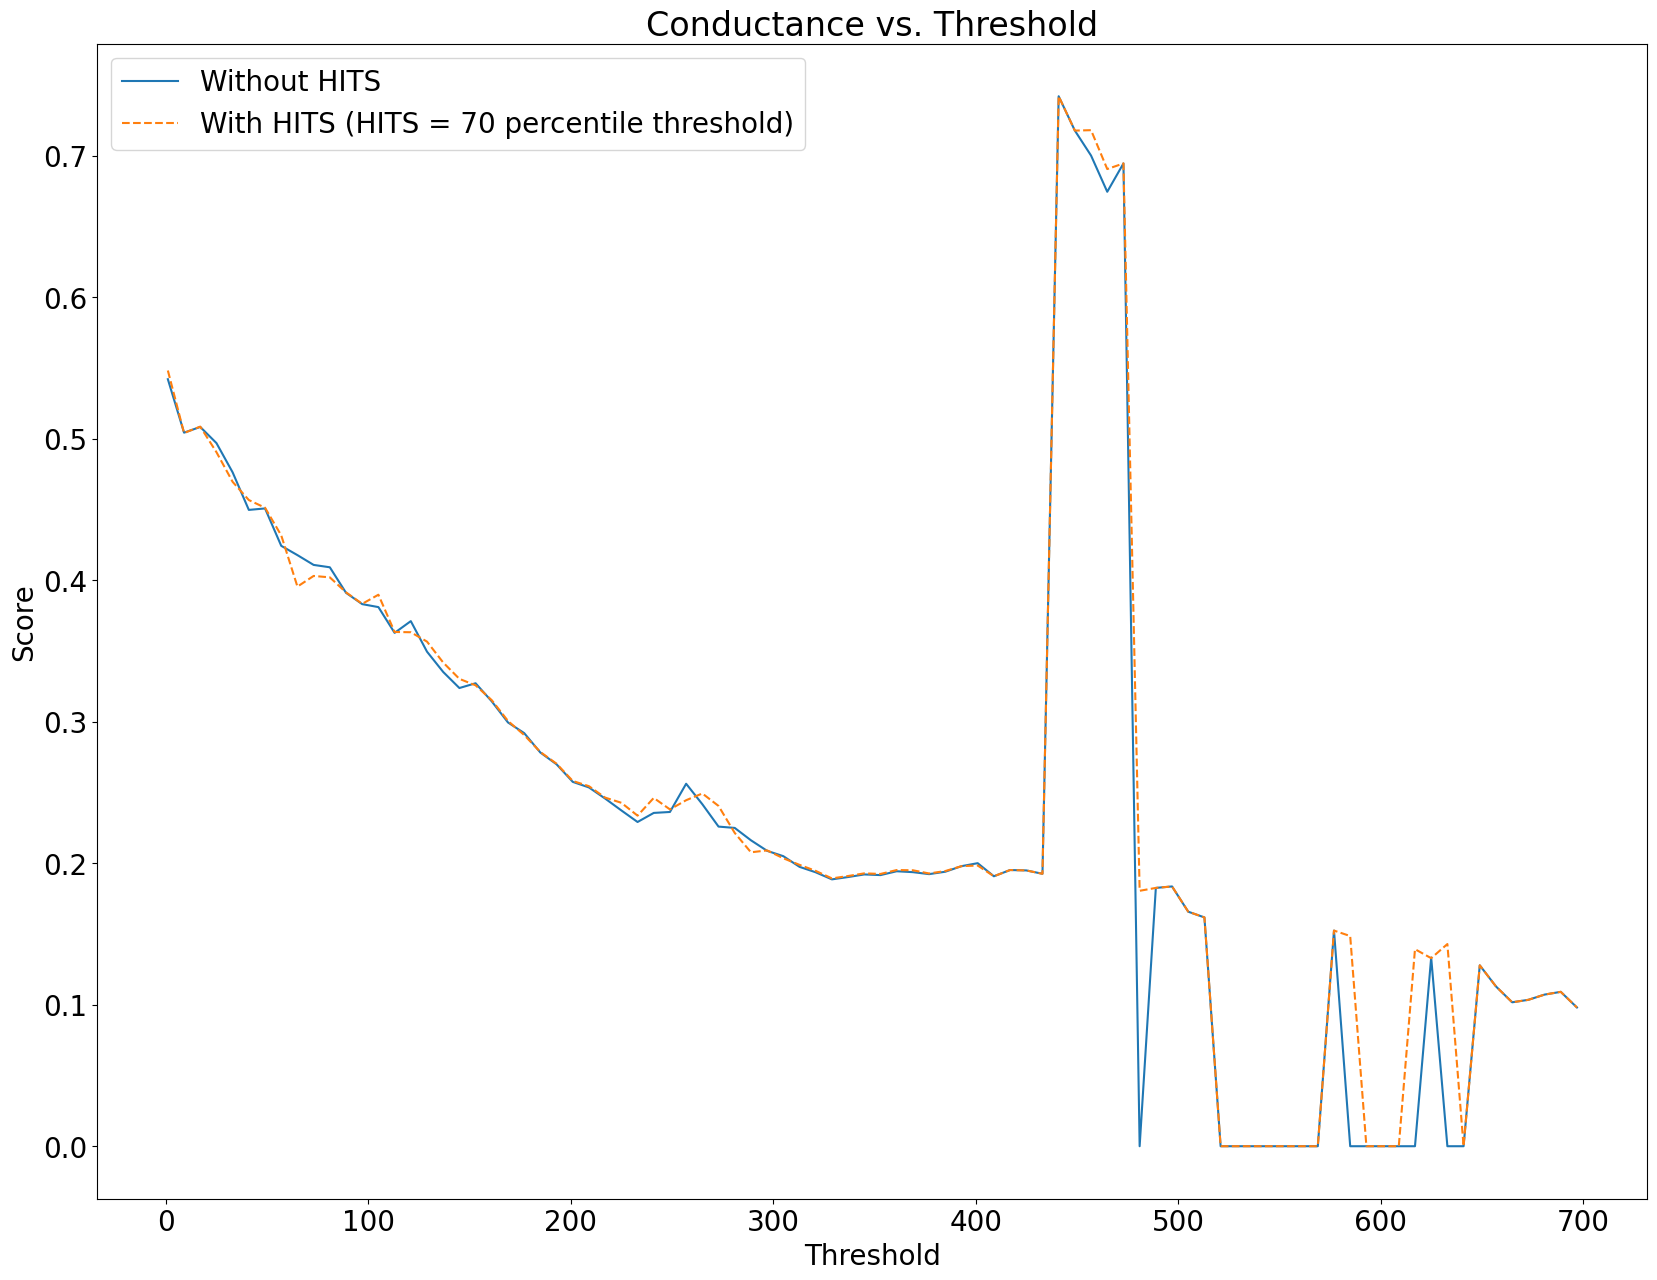

In [315]:
analyse_thresholds(df_data, 700, 8)

Experimenting with Without HITS without isolated nodes (HITS Threshold: None)
Experimenting with With HITS without isolated nodes (HITS Threshold: 70)


c:\Users\tusha\anaconda3\lib\site-packages\networkx\algorithms\link_analysis\hits_alg.py:78: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G, nodelist=list(G), dtype=float)
c:\Users\tusha\anaconda3\lib\site-packages\networkx\algorithms\link_analysis\hits_alg.py:78: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G, nodelist=list(G), dtype=float)
c:\Users\tusha\anaconda3\lib\site-packages\networkx\algorithms\link_analysis\hits_alg.py:78: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G, nodelist=list(G), dtype=float)
c:\Users\tusha\anaconda3\lib\site-packages\networkx\algorithms\link_analysis\hits_alg.py:78: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G, nodelist=li

{'Without HITS without isolated nodes': {'fcc': [0.8475609756097561, 0.9629629629629629, 0.9629629629629629, 0.9691358024691358, 0.9622641509433962, 0.9554140127388535, 0.967948717948718, 0.961038961038961, 0.9607843137254902, 0.96, 0.9664429530201343, 0.9659863945578231, 0.9591836734693877, 0.9577464788732394, 0.9574468085106383, 0.9642857142857143, 0.9642857142857143, 0.9712230215827338, 0.9705882352941176, 0.9850746268656716, 0.9849624060150376, 0.9849624060150376, 0.9846153846153847, 0.9844961240310077, 0.984375, 0.984251968503937, 0.9763779527559056, 0.984251968503937, 0.984, 0.7983870967741935, 0.8360655737704918, 0.8151260504201681, 0.8151260504201681, 0.8290598290598291, 0.8017241379310345, 0.8596491228070176, 0.8584070796460177, 0.8468468468468469, 0.8899082568807339, 0.8899082568807339, 0.8981481481481481, 0.8867924528301887, 0.8846153846153846, 0.8811881188118812, 0.8811881188118812, 0.9702970297029703, 0.9797979797979798, 0.979381443298969, 0.979381443298969, 0.978723404255

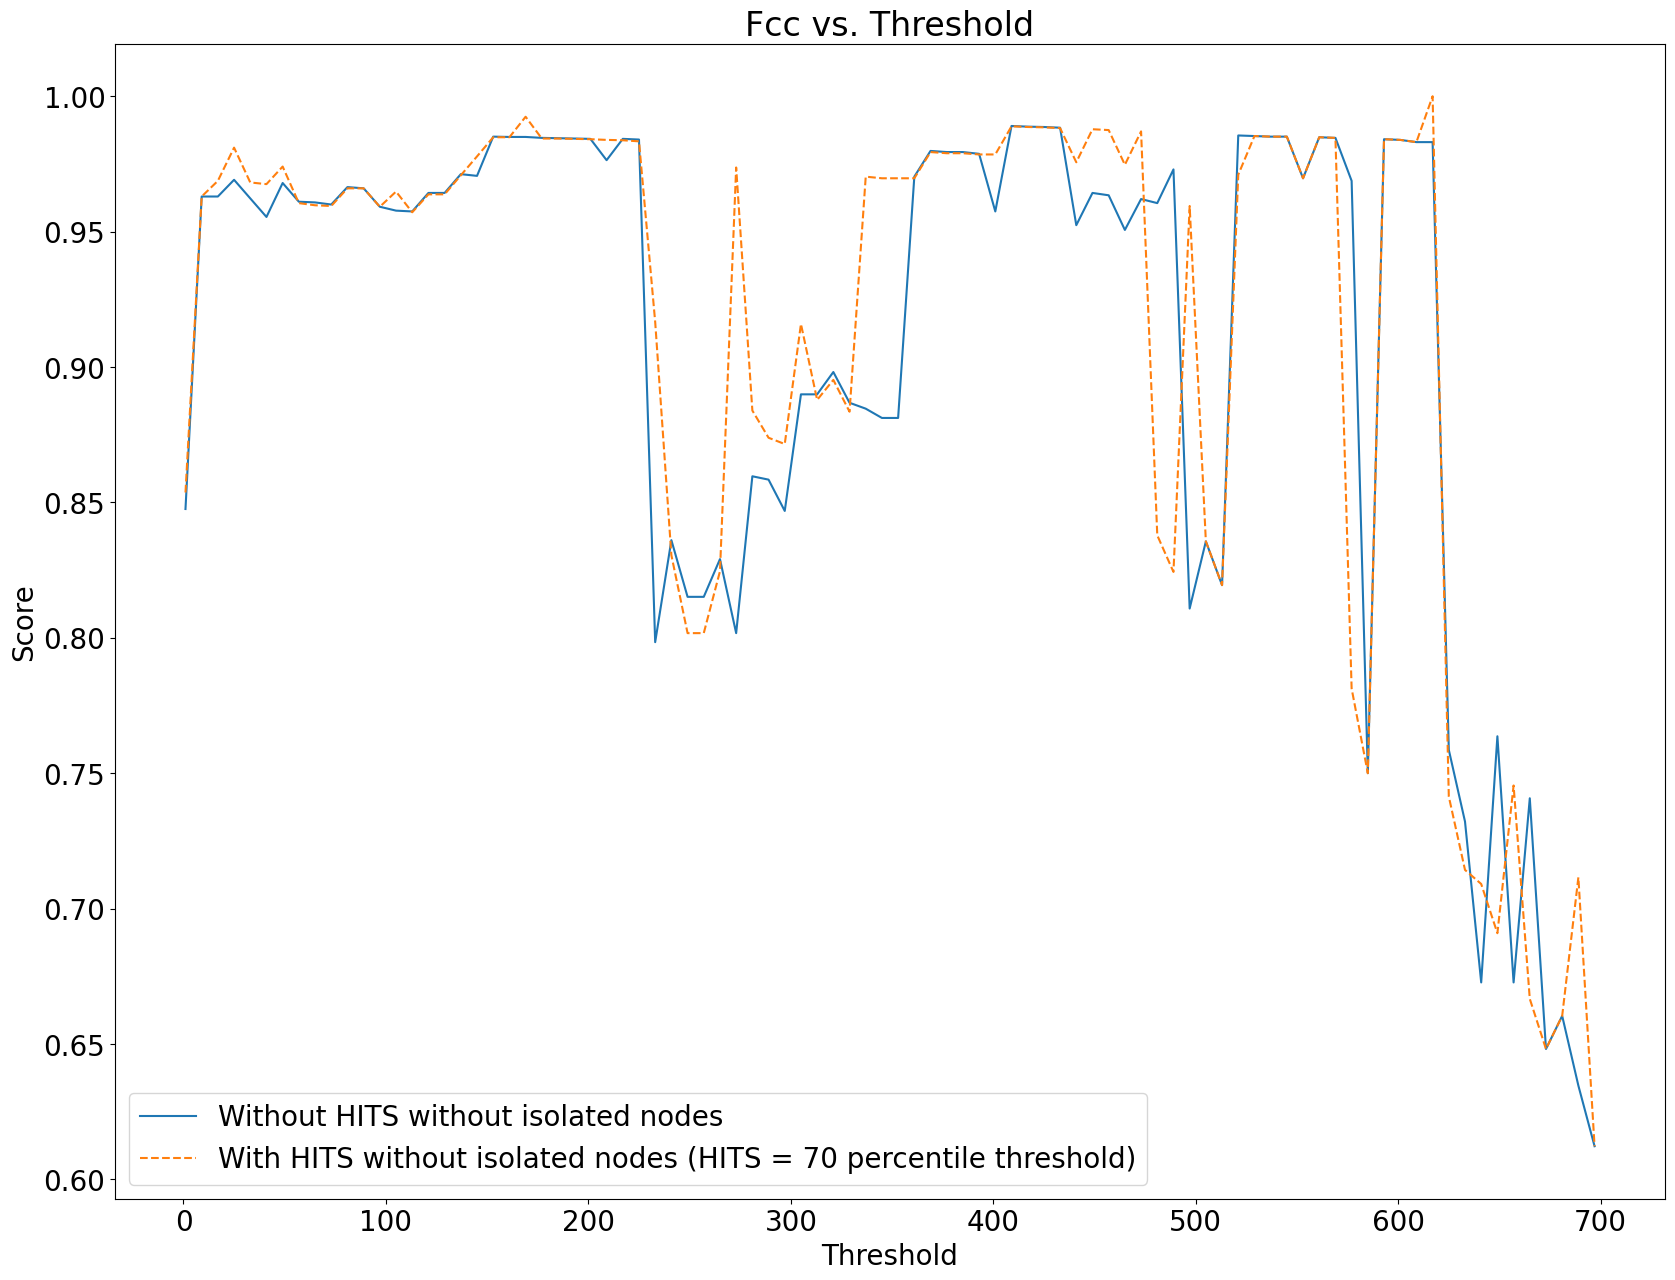

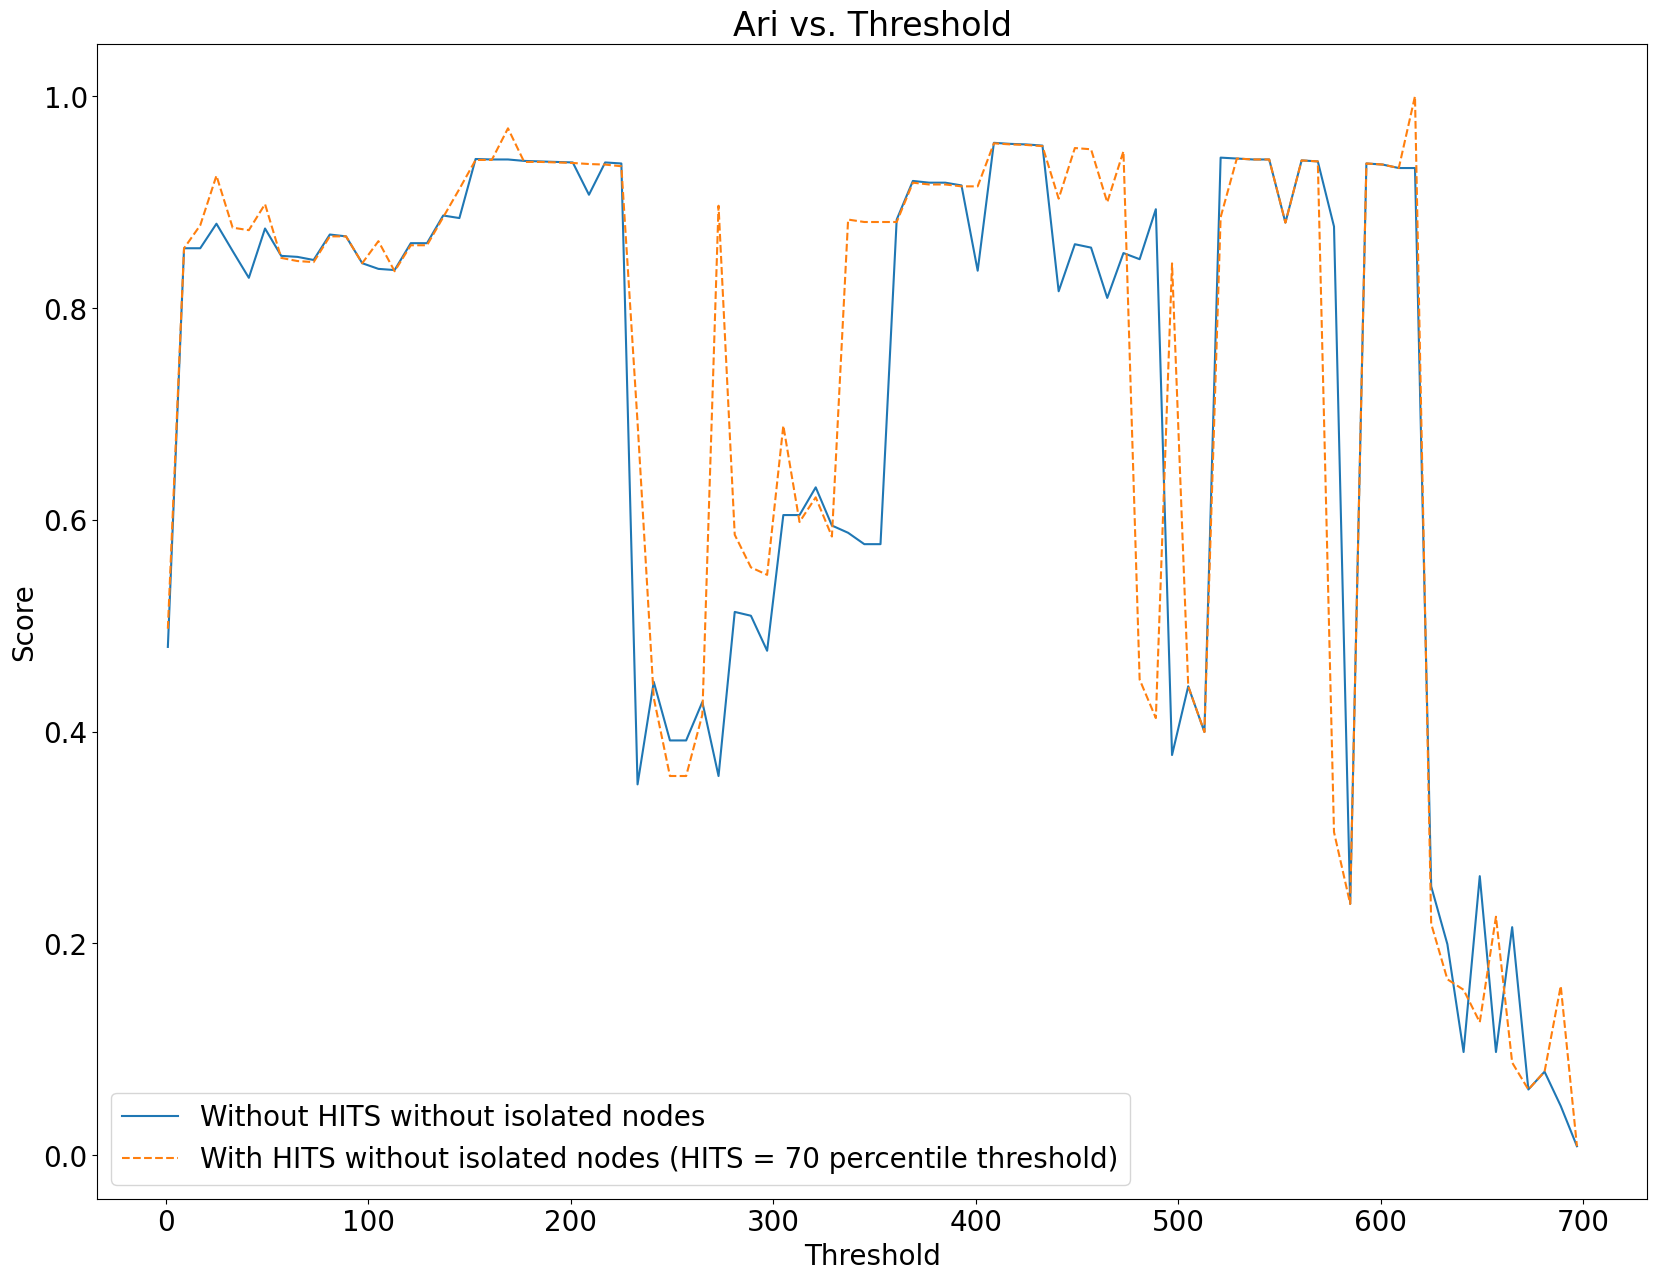

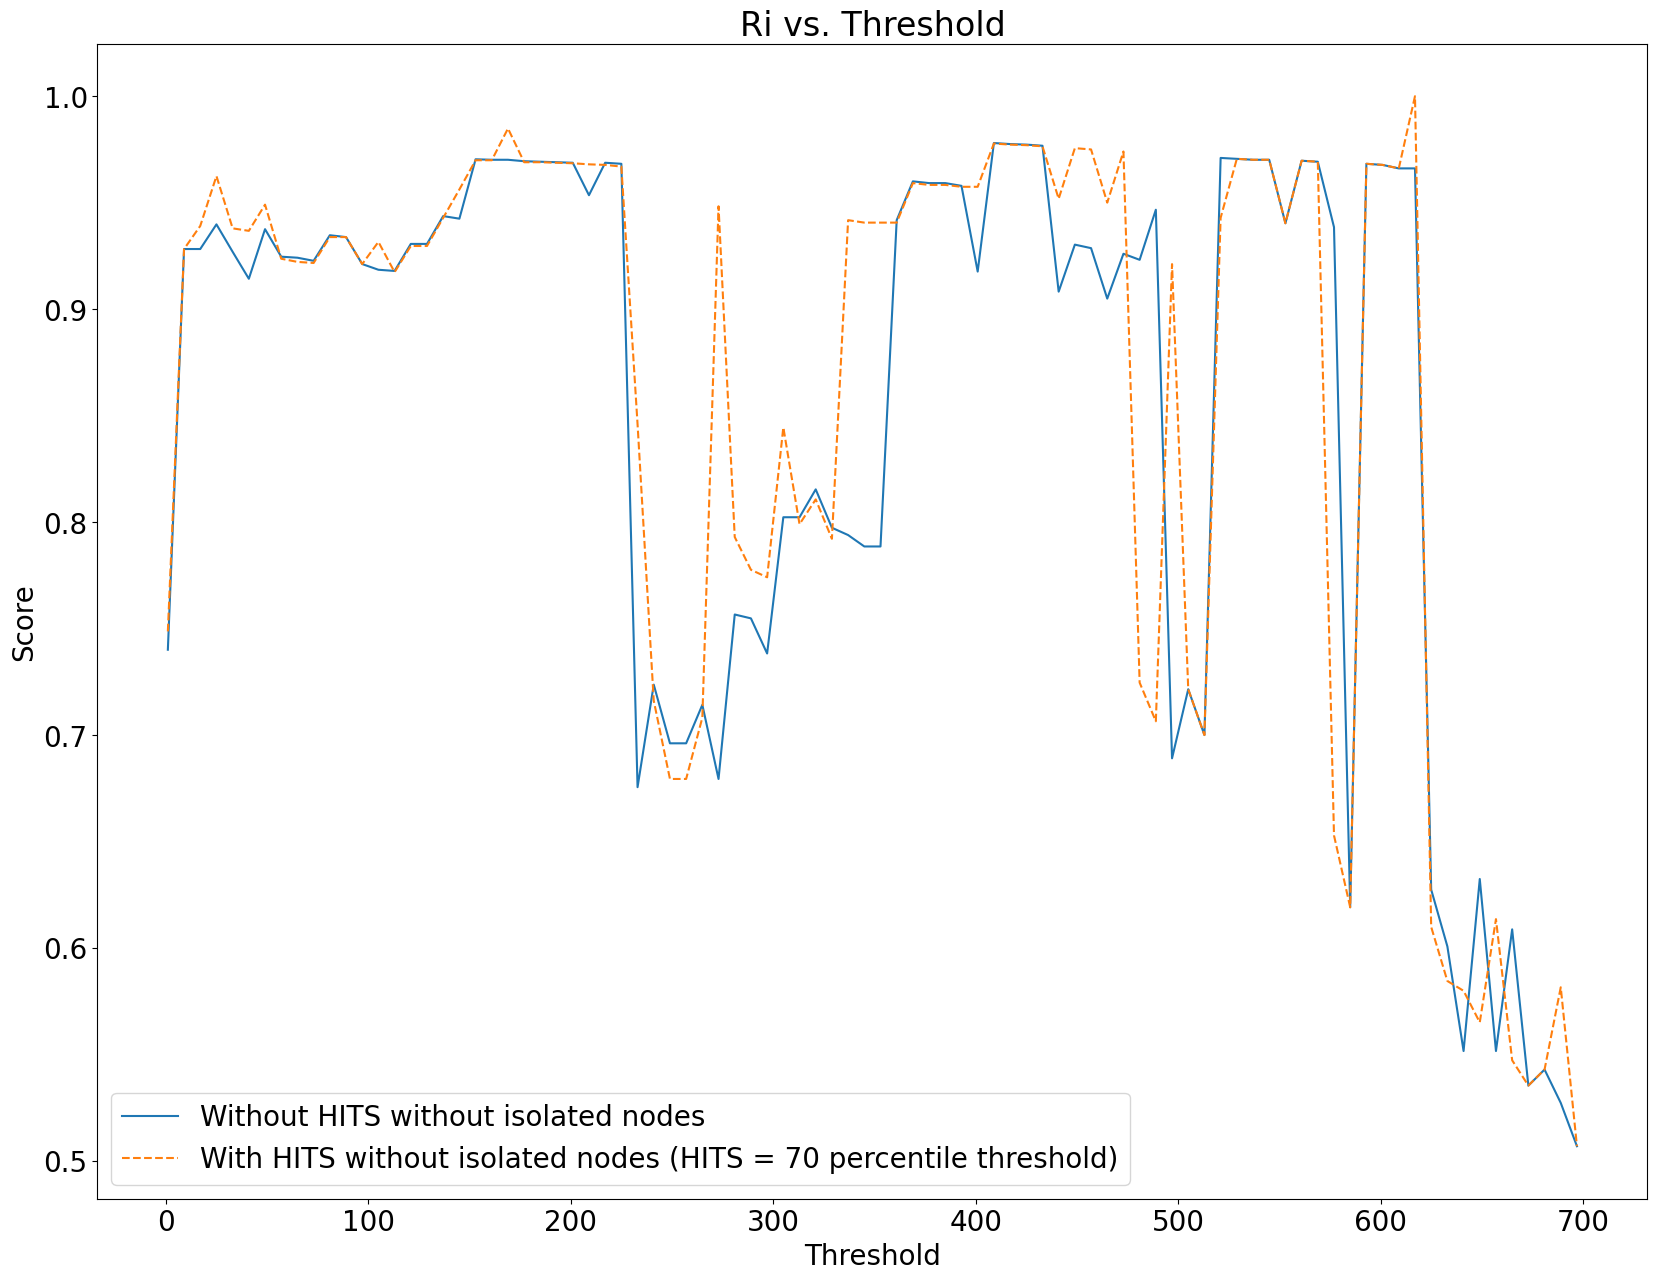

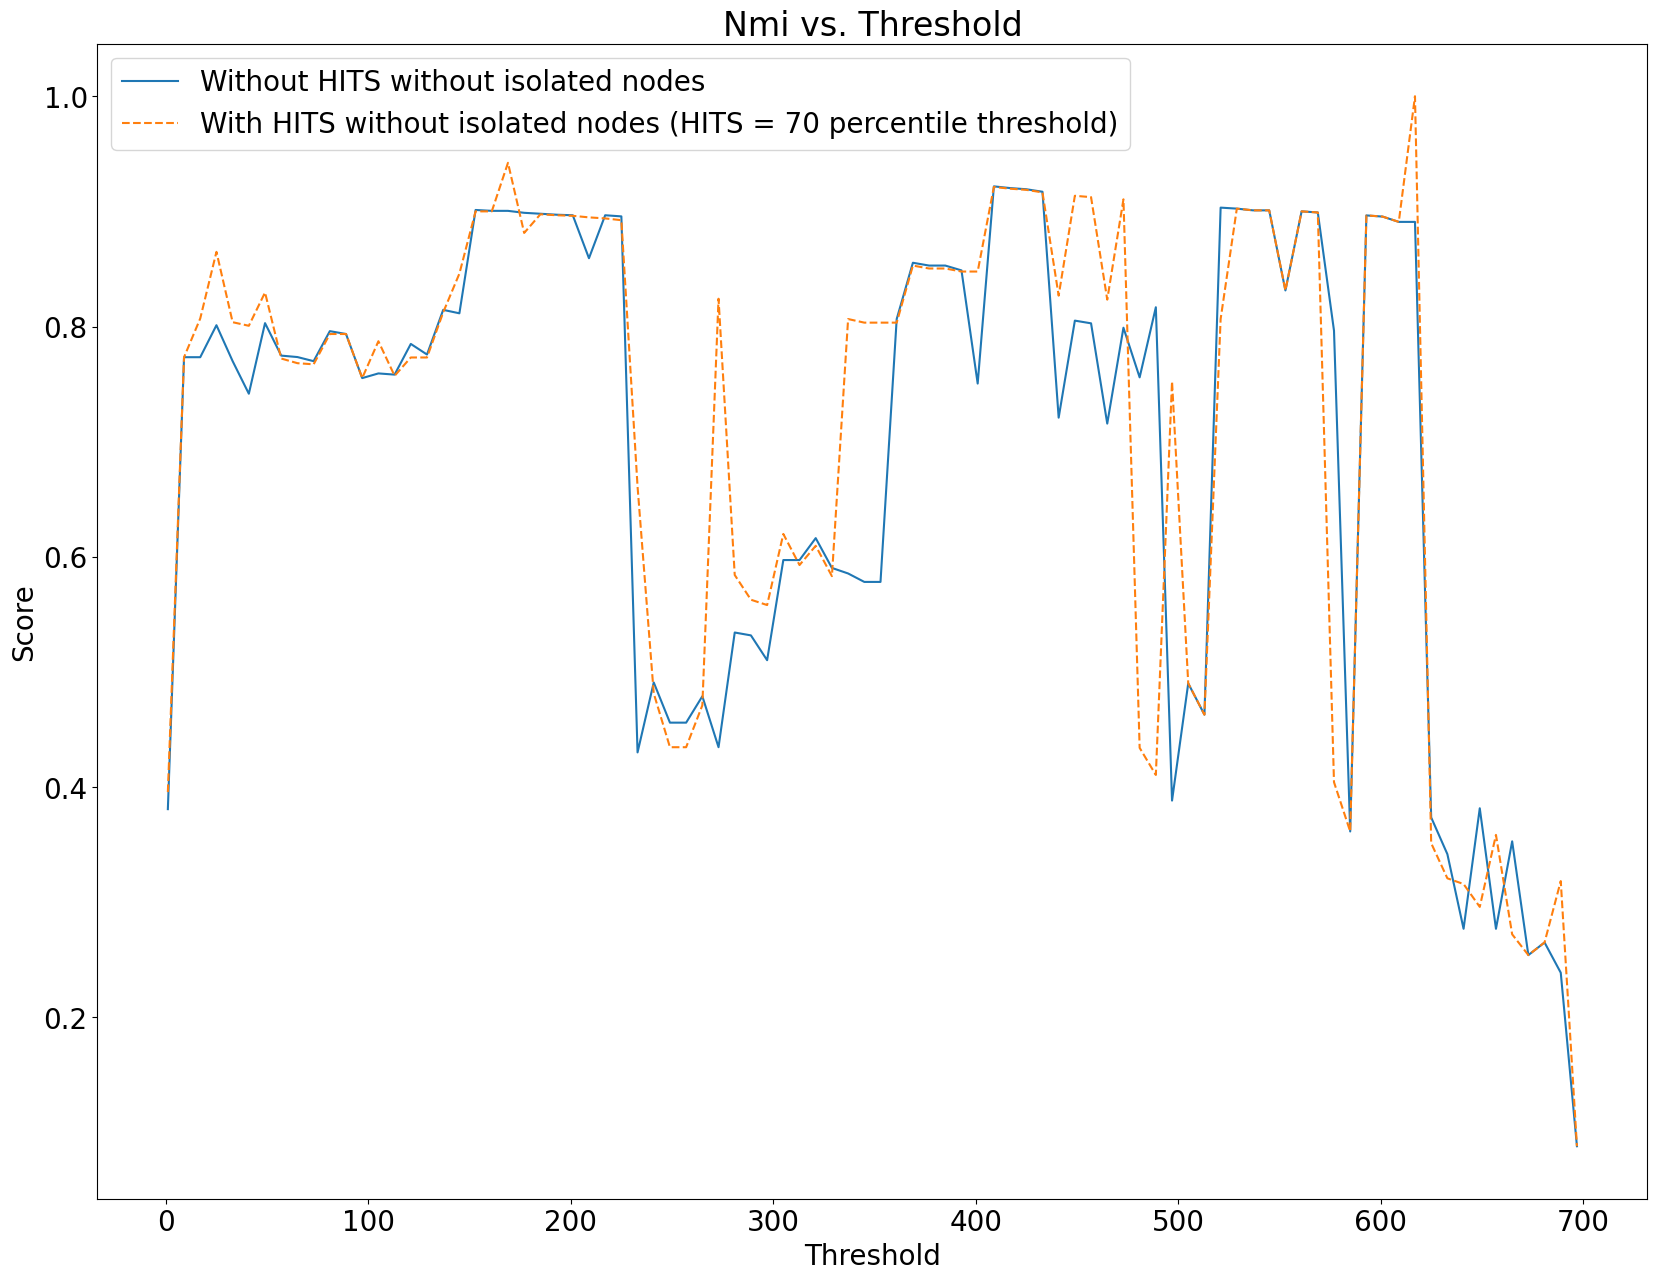

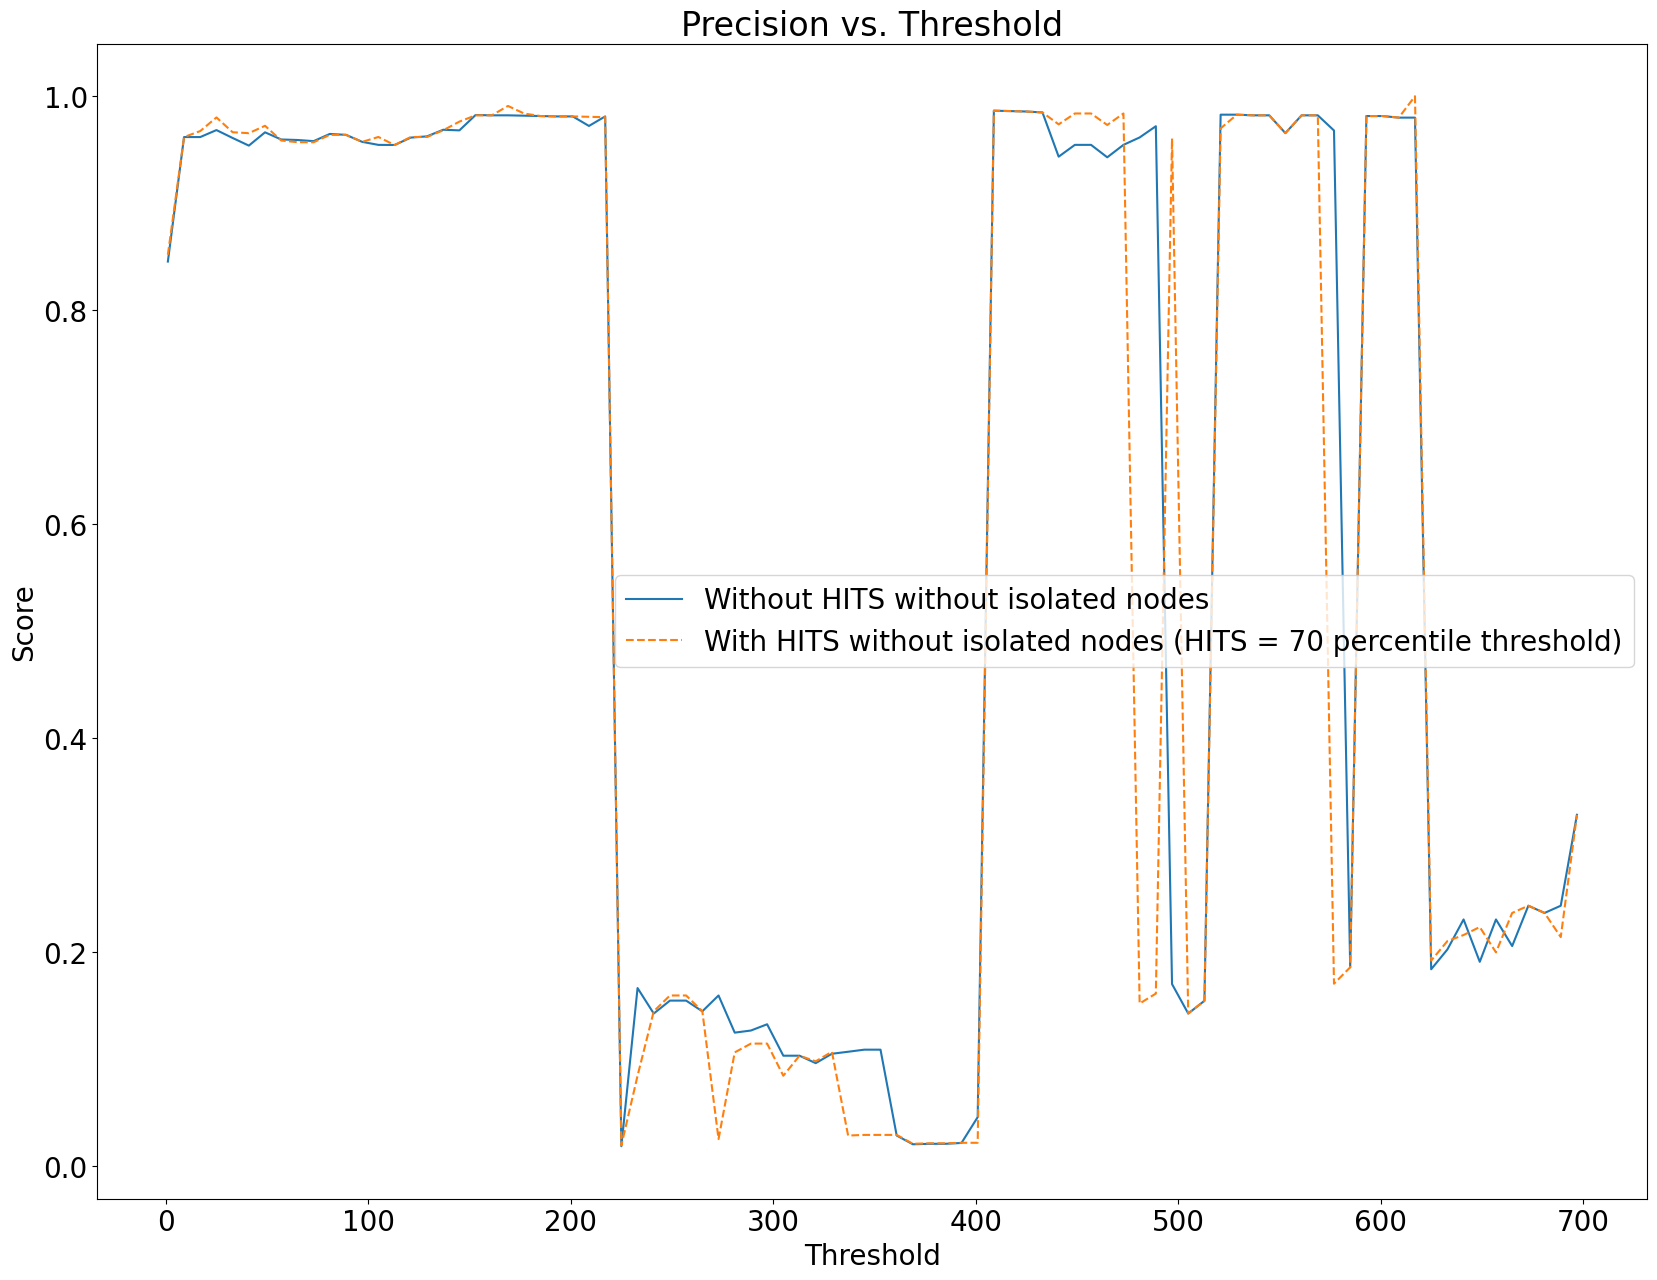

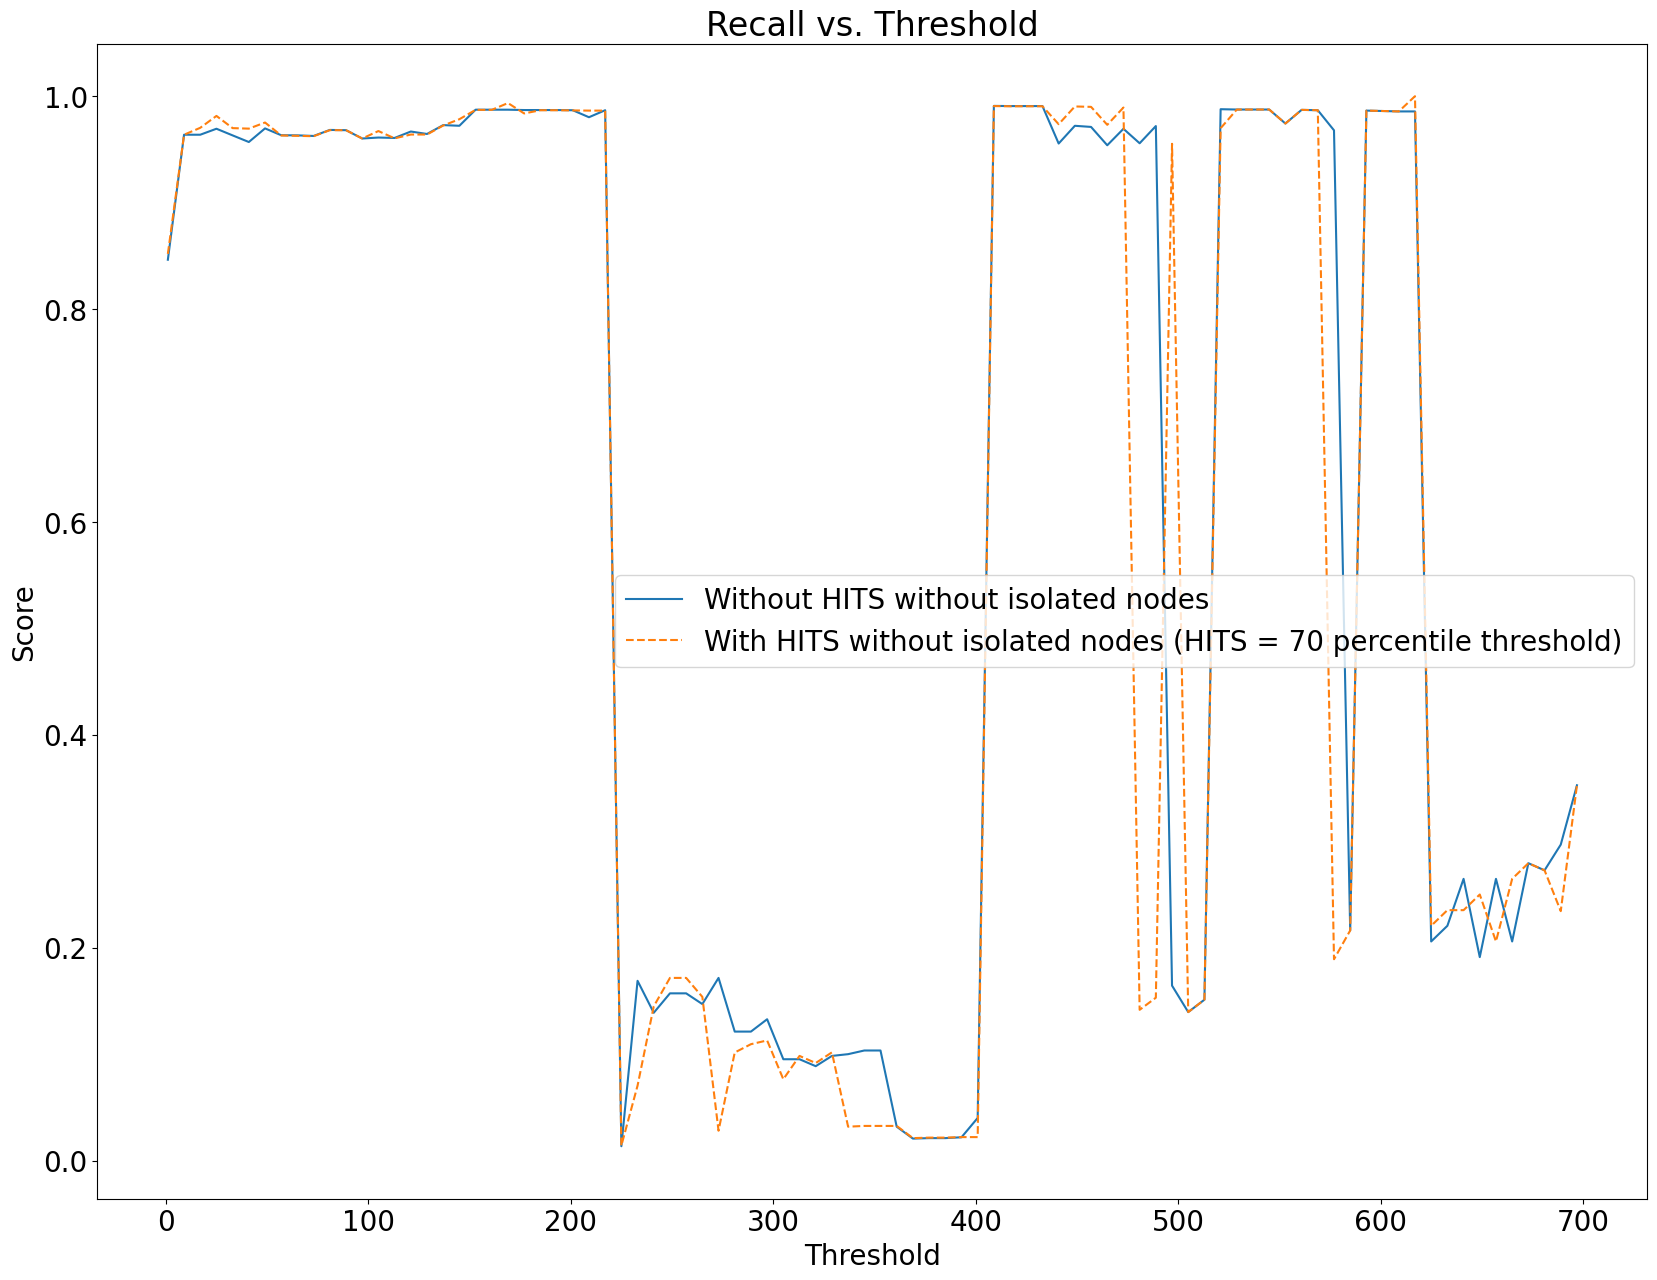

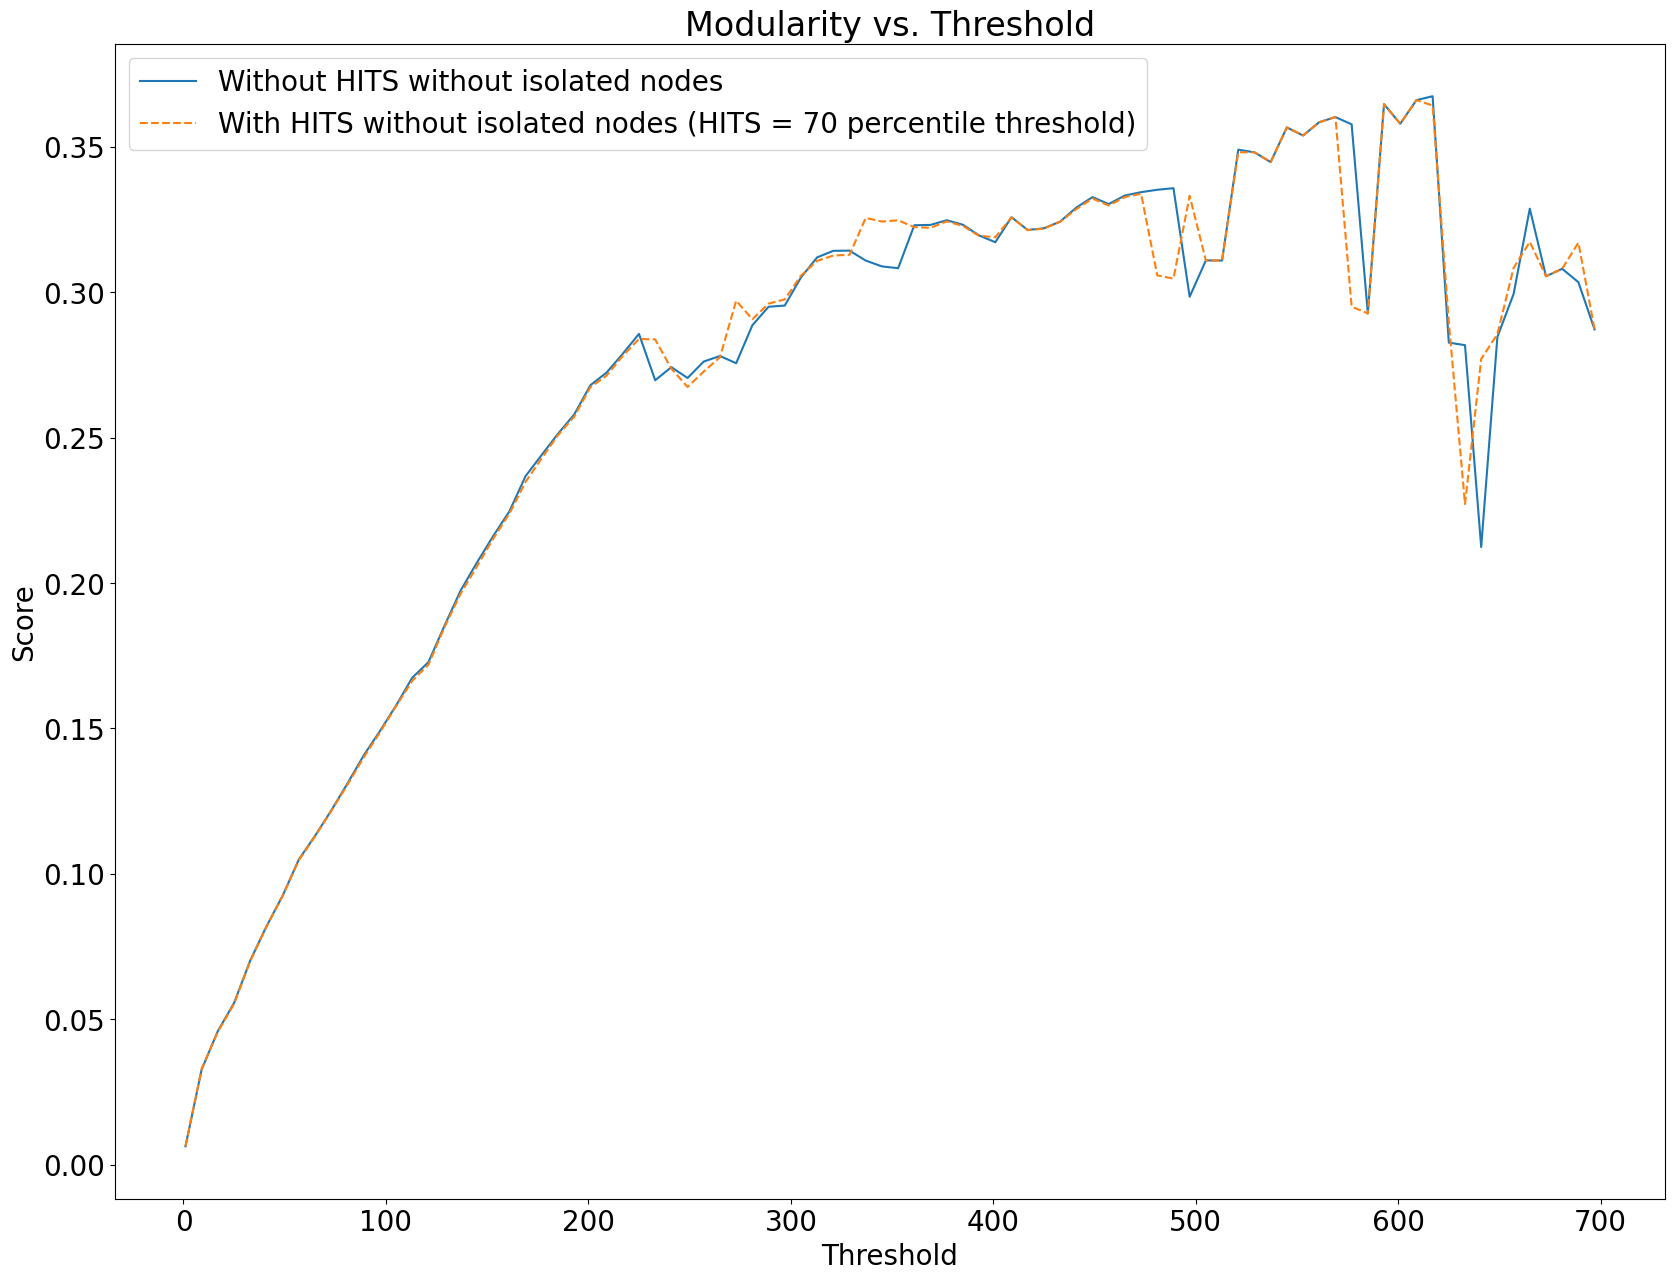

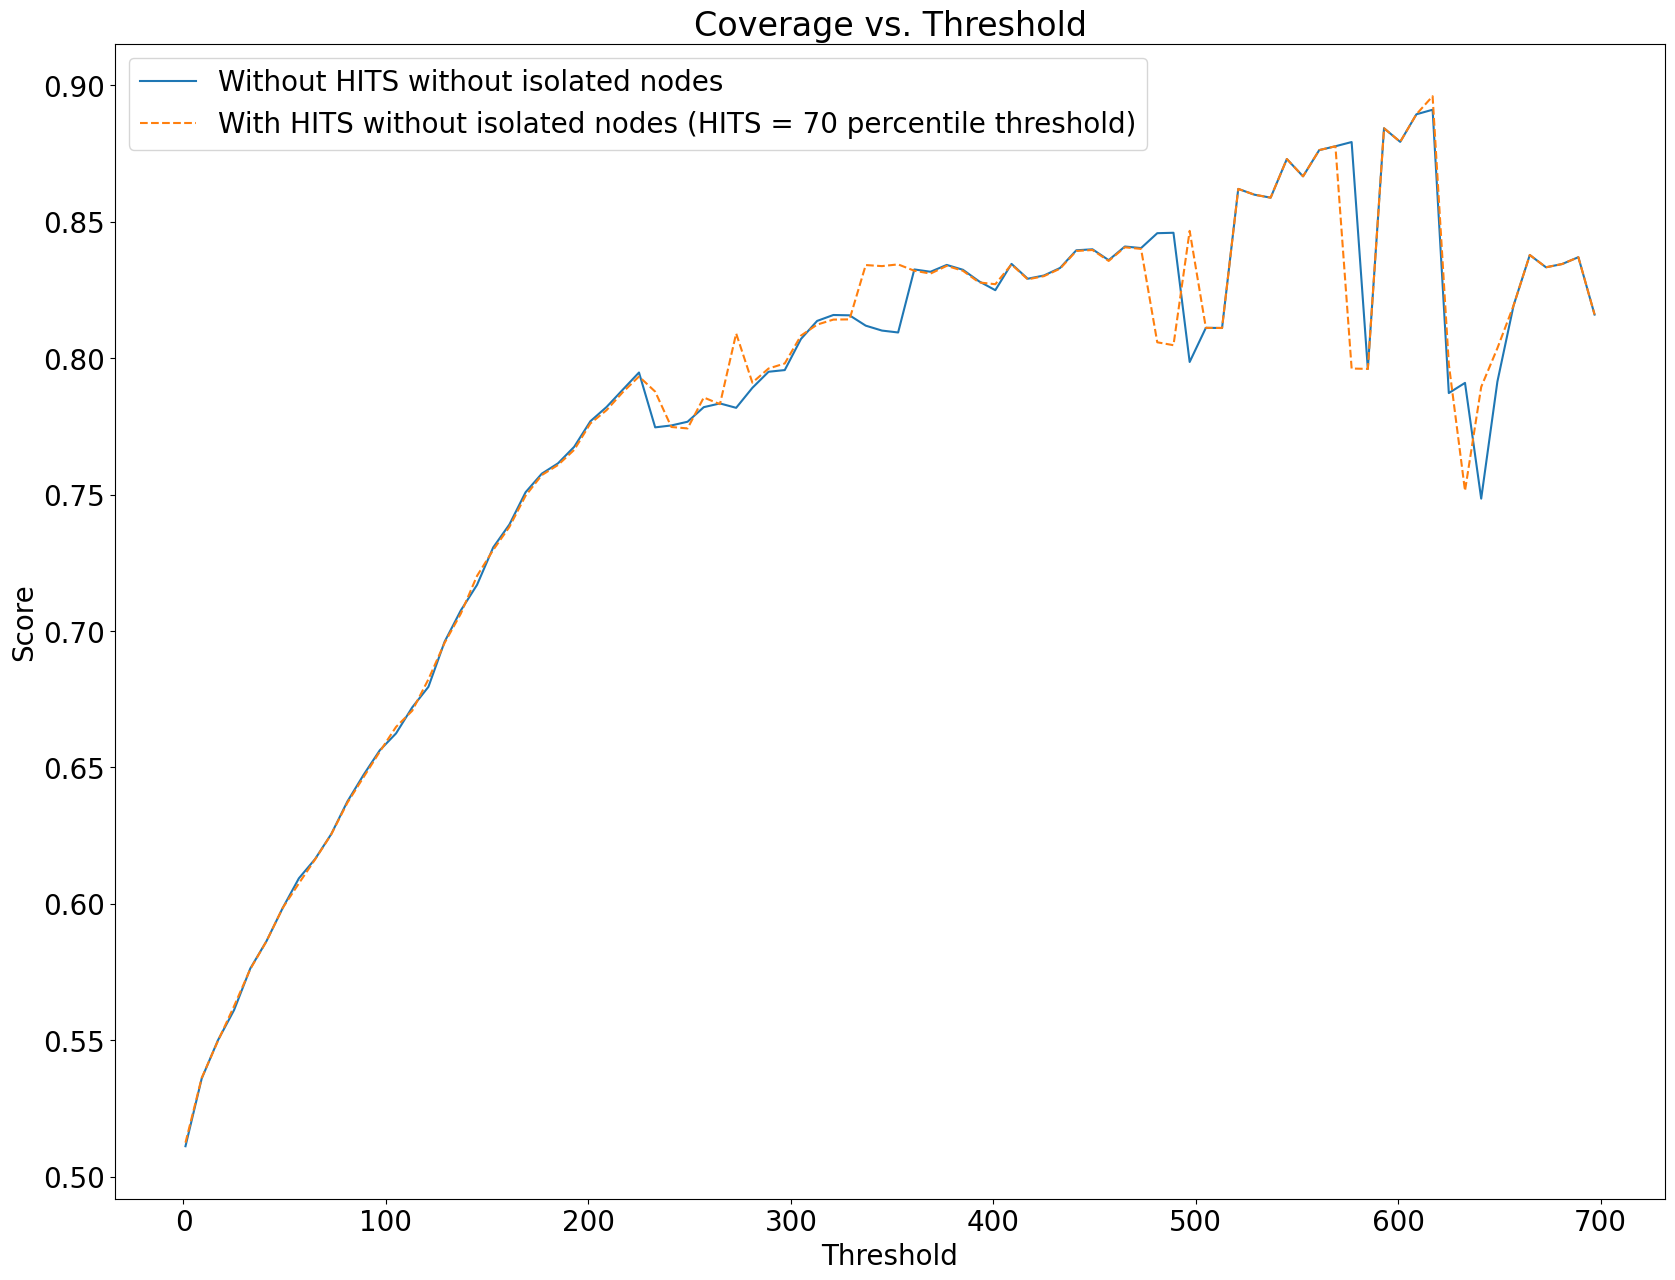

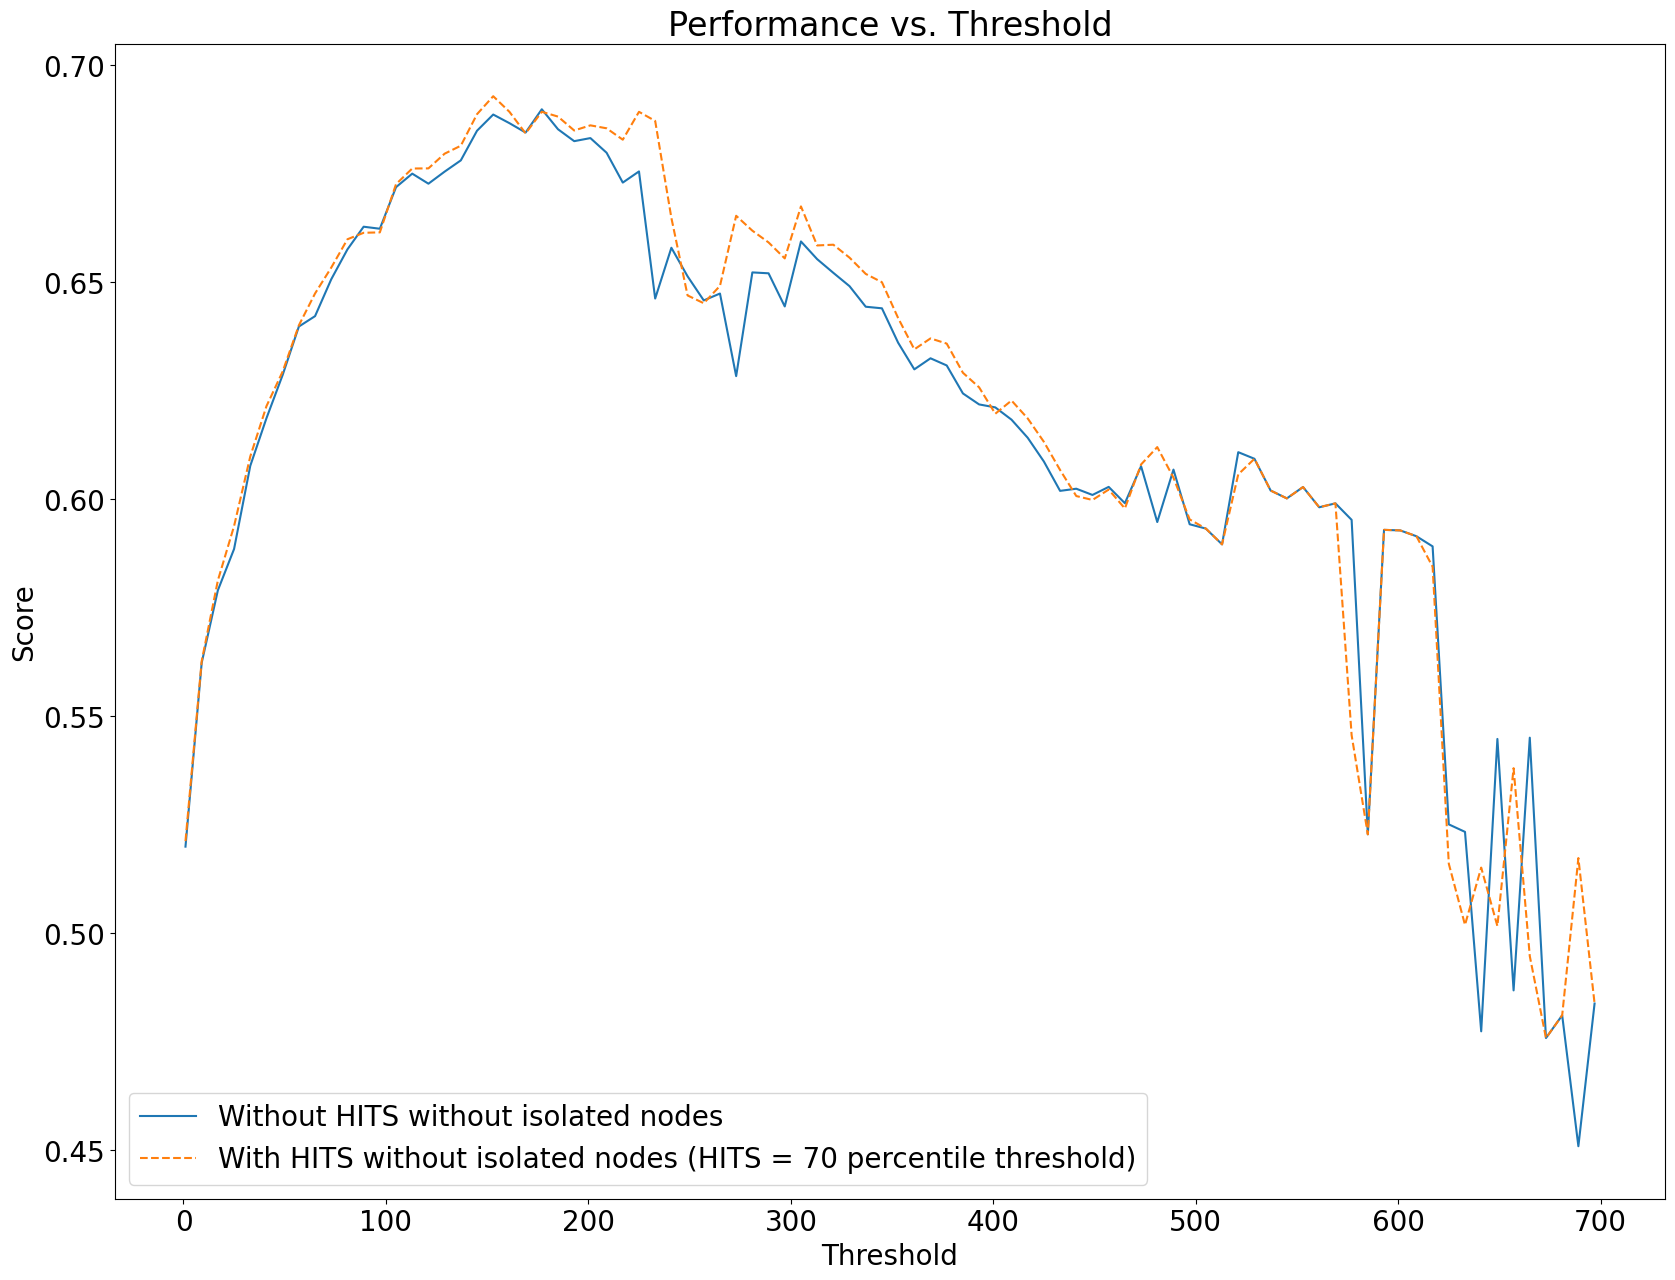

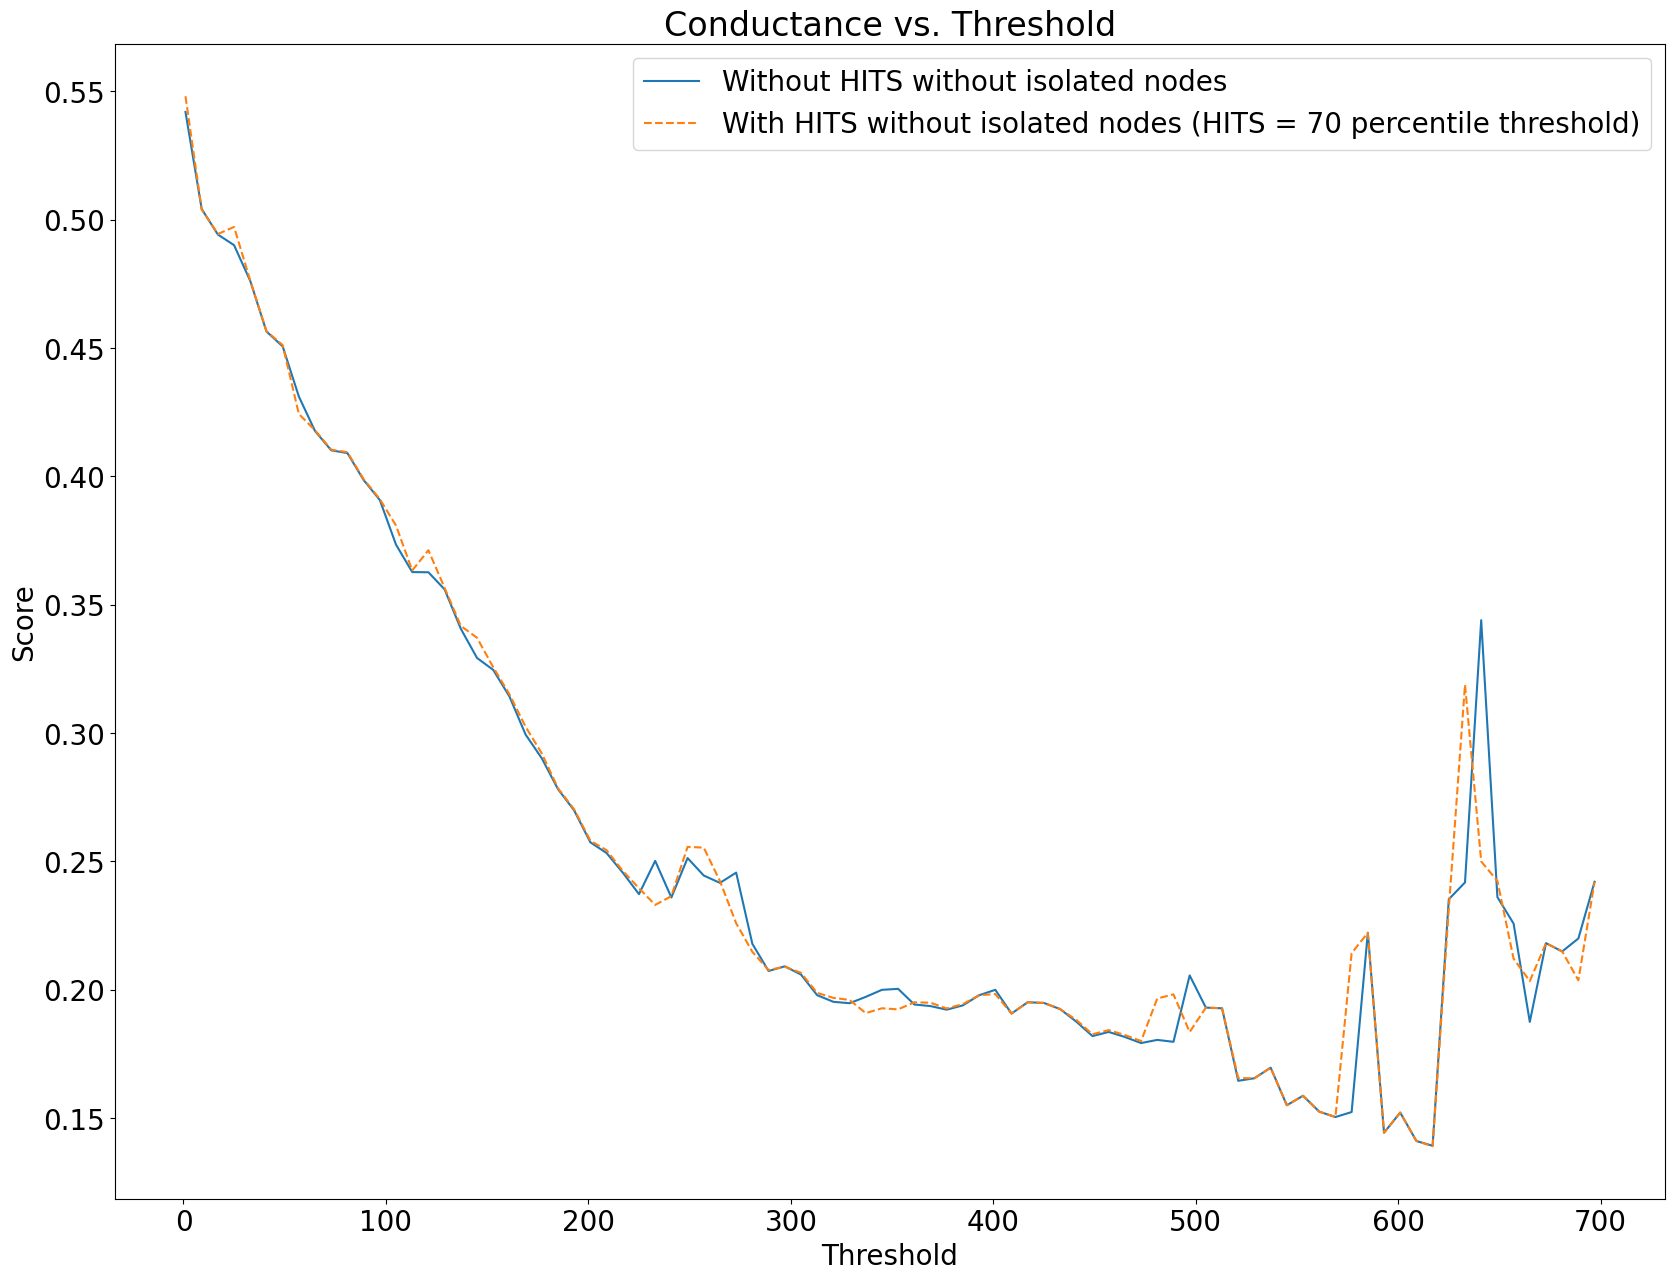

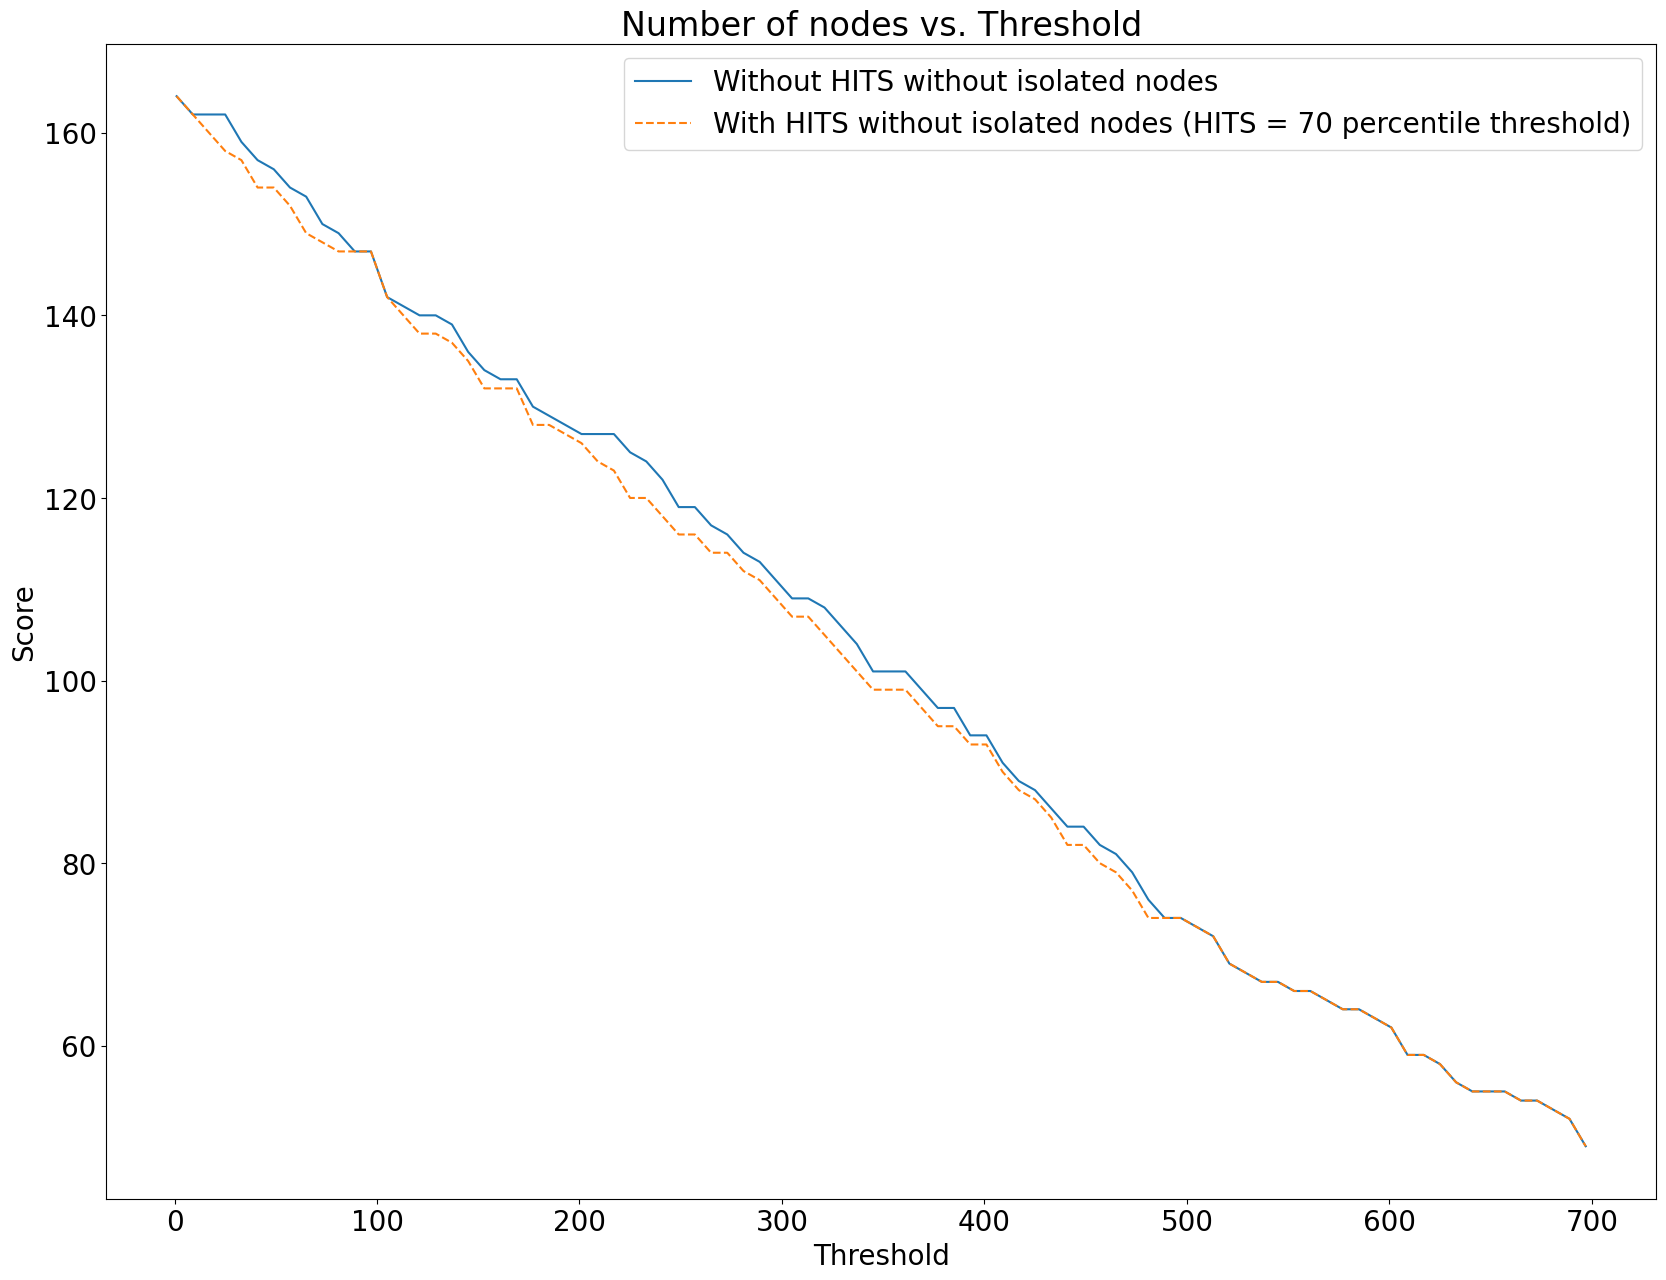

In [316]:
analyse_thresholds_iso(df_data, 700, 8)